# BCI Testbed for FATES

The purpose of this testbed code is to compare FATES output to observations at BCI, and also to understand some of the internal paramteric control over FATES predictions.  The overall order of things is to first load an ensemble of FATES model inputs, then look at several metrics of model predictions as projected onto the trait covariance matrices that were used to generate the model ensemble, and well as looking at several model predictions as compared to observed ecosystem states and fluxes at the BCI site.

#### First we will load all the libraries that we need

In [1]:
import netCDF4 as nc4
import numpy as np
import pandas as pd
#import seaborn as sns
#import matplotlib.pyplot as plt
#import dateutil.parser
#import datetime
import map_funcs
from IPython.display import Image
from scipy.optimize import curve_fit

# set the plot style
#plt.style.use('seaborn-ticks')
#sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5, "lines.markersize": 6.0, 'lines.markeredgewidth': 1.0})
#sns.set_context("poster")

#print(sns.__version__)

1.6.1


# First steps: load the data and define experimental structure


Load all the FATES history output that was generated by the model ensemble, as well as the traits matrix input to the model.


In [2]:
experiment_list = ['N PFTs experiment','2-PFT disturbance and structure experiment','10 PFT recruitment filtering experiment','ESM host experiment']
nexp = len(experiment_list)

experiment_list_shortnames = ['NPFTs_expt','twoPFTs_struct_expt','tenPFTs_recruit_expt','HLM_expt']

experiment_members_list_names = [
    ['1 PFT', 
     '3 PFTs', 
     '10 PFTs'],
    ['2 PFTs, stoch. sorting, intermed. dist.',
     '2 PFTs, deter. sorting, intermed. dist.',
     '2 PFTs, deter. sorting, ED dist.',
     '2 PFTs, deter. sorting, PPA dist.'],
    ['10 PFTs, seed mixing',
     '10 PFTs, no seed mixing'],
    ['ELM-FATES',
     'CLM-FATES']
]

experiment_members_list_cases = [
    ['fates_clm5_fullmodel_bci_parameter_ensemble_1pft_190329_multiinst_576inst_cont_moresizebins_b9c92b7_106ac7a', 
     'fates_clm5_fullmodel_bci_parameter_ensemble_2pfts_190416_multiinst_576inst_v3_cmpexcl3_b9c92b7_57b333d', 
     'fates_clm5_fullmodel_bci_parameter_ensemble_exp3_10pfts_190422_multiinst_576inst_v3_b9c92b7_cbd5280'],
    ['fates_clm5_fullmodel_bci_parameter_ensemble_2pfts_190416_multiinst_576inst_v3_cmpexcl3_b9c92b7_57b333d',
     'fates_clm5_fullmodel_bci_parameter_ensemble_2pfts_190408_multiinst_576inst_v2_b9c92b7_106ac7a',
     'fates_clm5_fullmodel_bci_parameter_ensemble_2pfts_190416_multiinst_576inst_pureEDdist_v2__b9c92b7_0bc7a5d',
     'fates_clm5_fullmodel_bci_parameter_ensemble_2pfts_190416_multiinst_576inst_purePPAdist_v2__b9c92b7_0bc7a5d'],
    ['fates_clm5_fullmodel_bci_parameter_ensemble_exp3_10pfts_190422_multiinst_576inst_v3_b9c92b7_cbd5280',
     'fates_clm5_fullmodel_bci_parameter_ensemble_exp3_10pfts_nomixing_190425_multiinst_576inst_v1_b9c92b7_0ea6de7'],
    ['fates_e3sm_fullmodel_bci_parameter_ensemble_1pft_190329_multiinst_576inst_544db3b_0bc7a5d',
     'fates_clm5_fullmodel_bci_parameter_ensemble_1pft_190329_multiinst_576inst_cont_moresizebins_b9c92b7_106ac7a',
     ]
]

expt_mem_years = [
    [[0,50], 
     [150,200], 
     [150,200]],
    [[250,300],
     [250,300],
     [250,300],
     [250,300]],
    [[150,200],
     [150,200]],
    [[150,200],
     [0,50]]
]

n_members_per_expt = []
for i in range(nexp):
    n_members_per_expt.append(len(experiment_members_list_names[i]))

print('n_members_per_expt',n_members_per_expt)

max_expt_members = max(n_members_per_expt)

### now loop through and load the datasets
fates_history_files_h0 = []
fates_history_files_h1 = []

history_file_path = '/Users/cdkoven/datasets/fates_output/bci_testbed/'
suffix_h0 = '.h0.ensemble.sofar.nc'
suffix_h1 = '.h1.ensemble.sofar.nc'

for i in range(nexp):
    fates_history_files_h0.append([])
    fates_history_files_h1.append([])
    for j in range(n_members_per_expt[i]):
        fates_history_files_h0[i].append(nc4.Dataset(history_file_path+experiment_members_list_cases[i][j]+suffix_h0))
        fates_history_files_h1[i].append(nc4.Dataset(history_file_path+experiment_members_list_cases[i][j]+suffix_h1))
        
n_ens_members = 576

colorlist = [
    [5, 
     33, 
     65],
    [4,
     77,
     126,
     160],
    [25,
     60],
    [50,
     100]
]

('n_members_per_expt', [3, 4, 2, 2])


 
showing file gpp_hist_NPFTs_expt


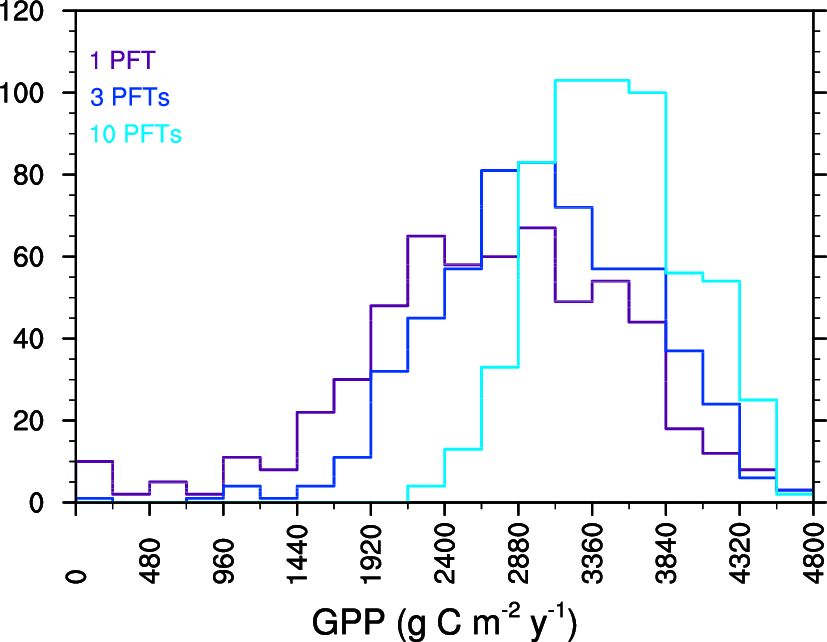

 
showing file lai_hist_NPFTs_expt


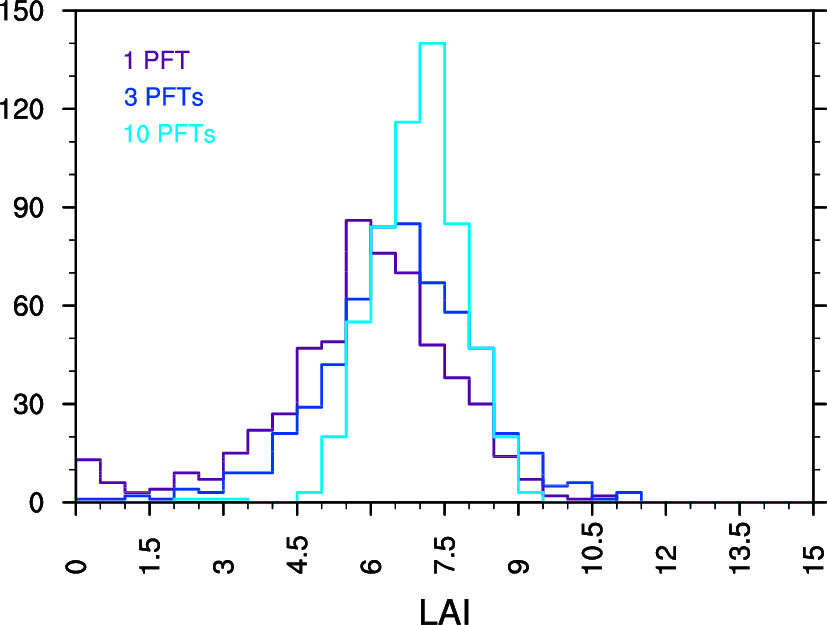

 
showing file biomass_hist_NPFTs_expt


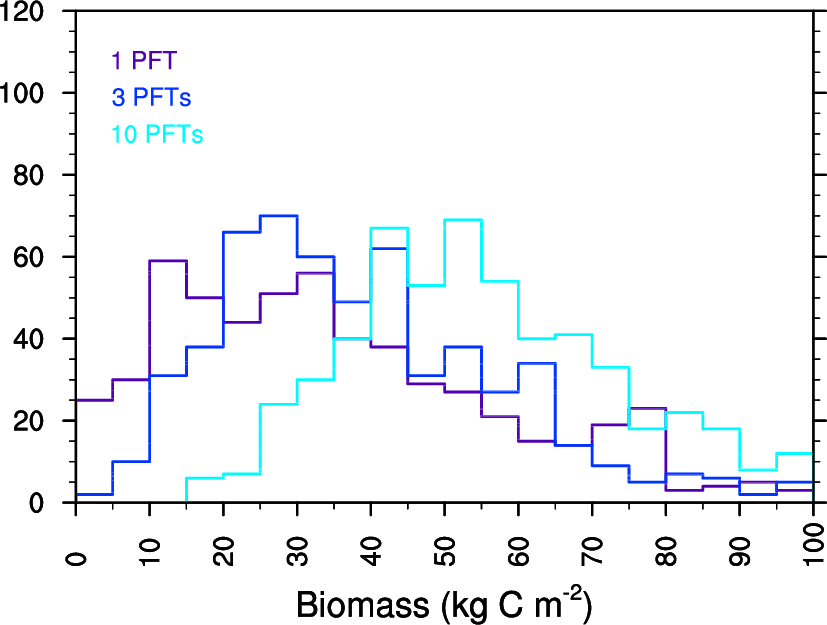

 
showing file gpp_hist_twoPFTs_struct_expt


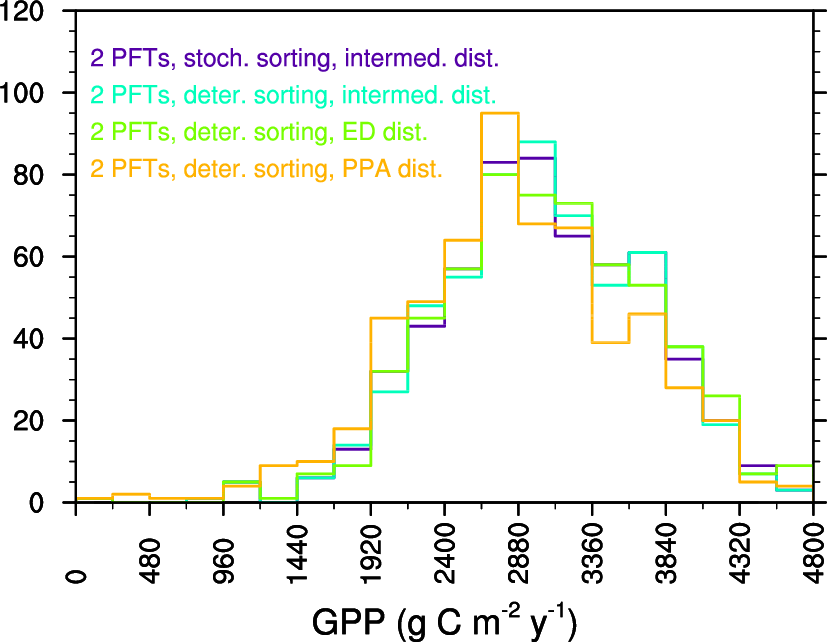

 
showing file lai_hist_twoPFTs_struct_expt


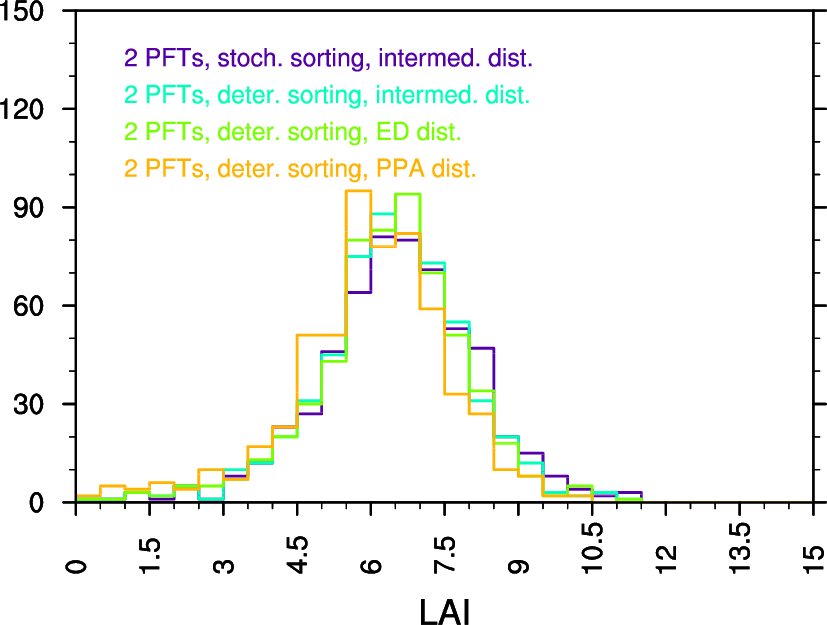

 
showing file biomass_hist_twoPFTs_struct_expt


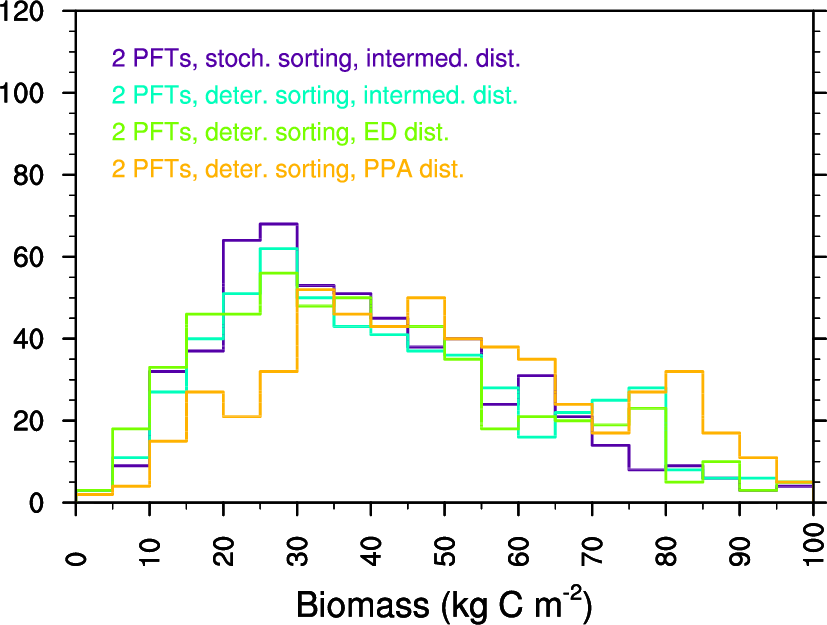

 
showing file gpp_hist_tenPFTs_recruit_expt


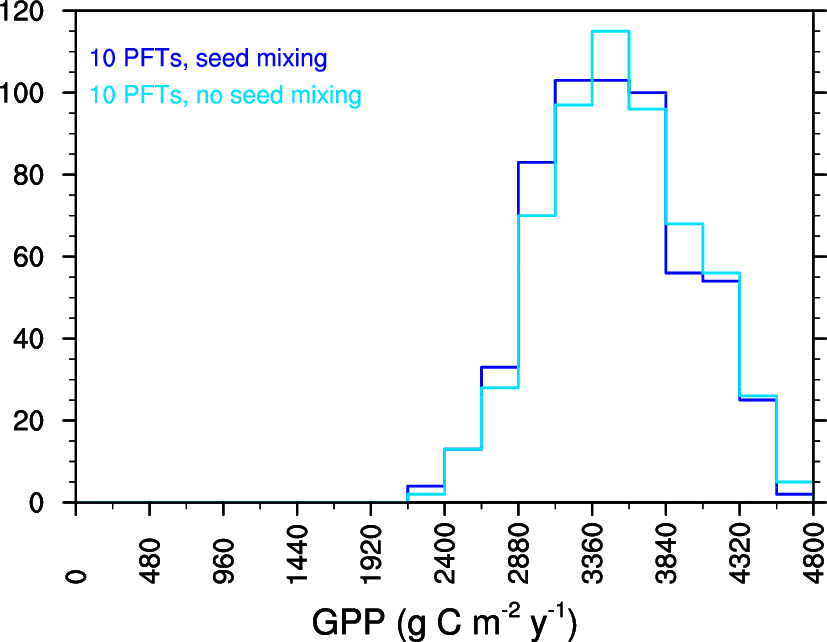

 
showing file lai_hist_tenPFTs_recruit_expt


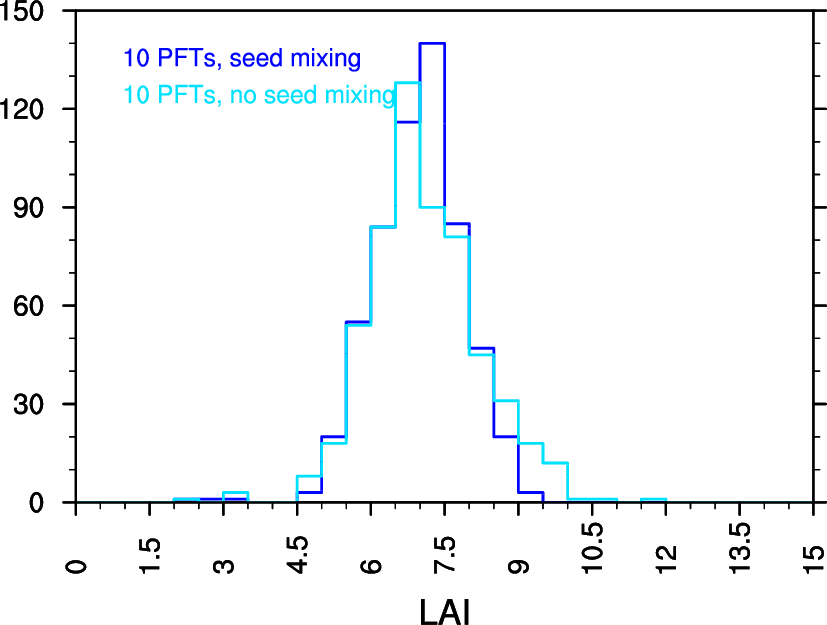

 
showing file biomass_hist_tenPFTs_recruit_expt


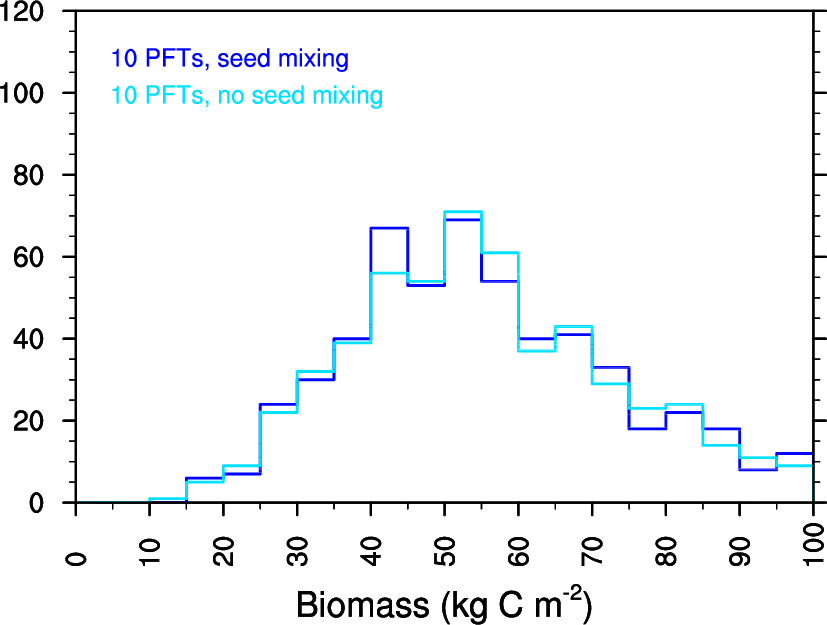

 
showing file gpp_hist_HLM_expt


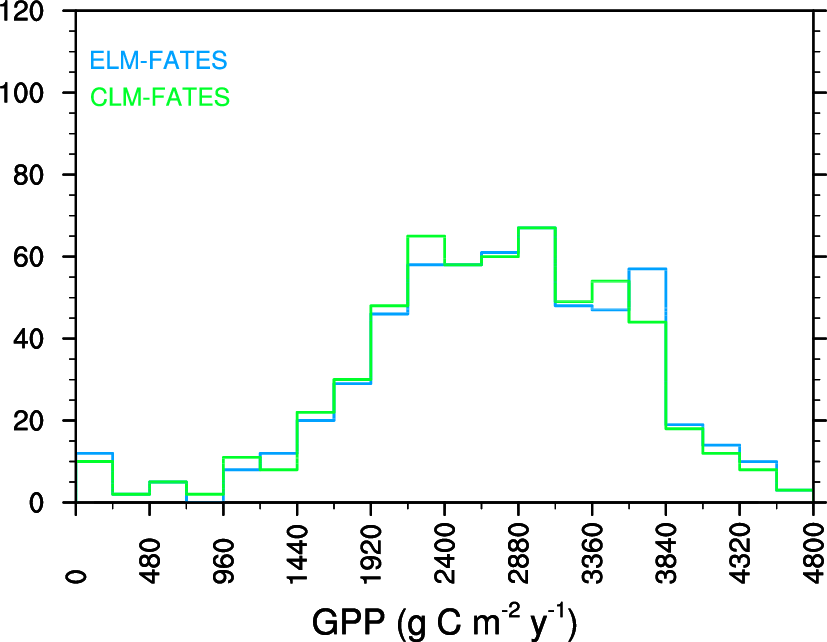

 
showing file lai_hist_HLM_expt


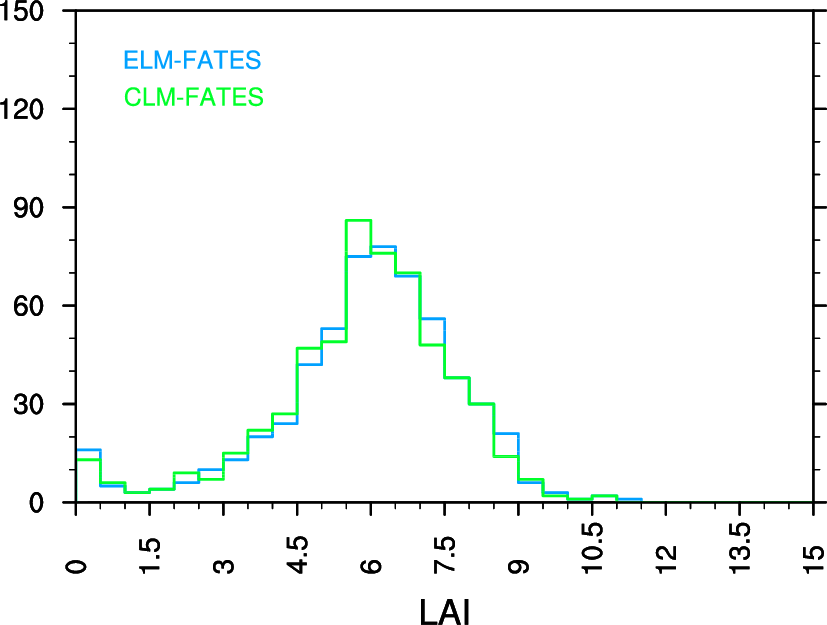

 
showing file biomass_hist_HLM_expt


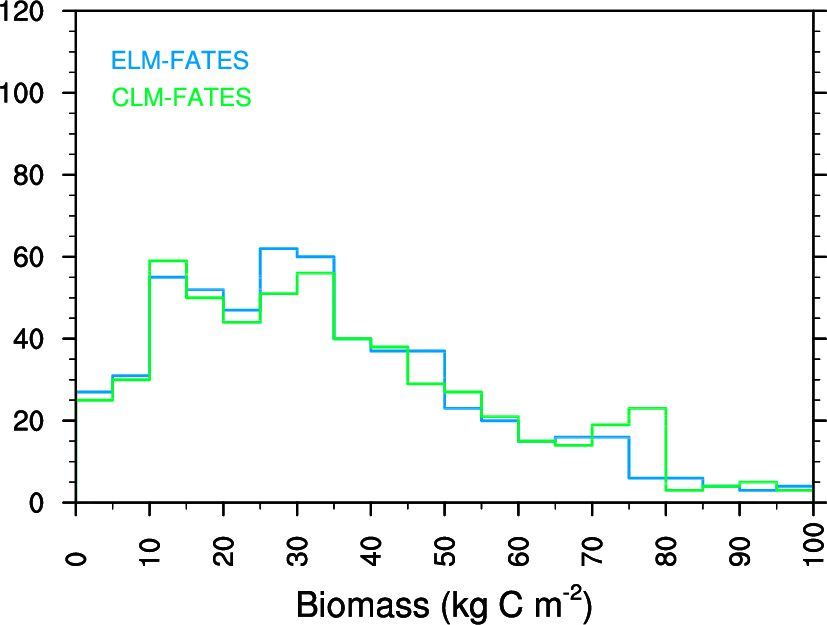

In [3]:
## load the mean GPP, LAI, biomass of each ensemble member and each experiment

mean_gpp = np.ma.masked_all([nexp,max_expt_members,n_ens_members])
mean_lai = np.ma.masked_all([nexp,max_expt_members,n_ens_members])
mean_biomass = np.ma.masked_all([nexp,max_expt_members,n_ens_members])

for i in range(nexp):
    for j in range(n_members_per_expt[i]):
        mean_gpp[i,j,:] = fates_history_files_h0[i][j].variables['GPP'][:,expt_mem_years[i][j][0]*12:expt_mem_years[i][j][1]*12,0].mean(axis=1)
        mean_lai[i,j,:] = fates_history_files_h0[i][j].variables['ELAI'][:,expt_mem_years[i][j][0]*12:expt_mem_years[i][j][1]*12,0].mean(axis=1)
        mean_biomass[i,j,:] = fates_history_files_h0[i][j].variables['ED_biomass'][:,expt_mem_years[i][j][0]*12:expt_mem_years[i][j][1]*12,0].mean(axis=1)

        ## , colormap='amwg256'
## print(mean_gpp.mean(axis=2))
        
for i in range(nexp):
        map_funcs.plot_histogram(mean_gpp[i,0:n_members_per_expt[i],:]*86400*365, bins=20, therange=[0.,4800.], axis=0, yaxis_top=120, labels=experiment_members_list_names[i], colors=colorlist[i], label_xstart=100, file='gpp_hist_'+experiment_list_shortnames[i], aspect_ratio=1.5,xtitle='GPP (g C m~S~-2~N~ y~S~-1~N~)', showjupyter=True)
        map_funcs.plot_histogram(mean_lai[i,0:n_members_per_expt[i],:], bins=30, therange=[0.,15.], axis=0, yaxis_top=150, labels=experiment_members_list_names[i], colors=colorlist[i], label_xstart=1, file='lai_hist_'+experiment_list_shortnames[i], aspect_ratio=1.5, xtitle='LAI', showjupyter=True)
        map_funcs.plot_histogram(mean_biomass[i,0:n_members_per_expt[i],:]*1e-3, bins=20, therange=[0.,100.], axis=0, yaxis_top=120, labels=experiment_members_list_names[i], colors=colorlist[i], label_xstart=5, file='biomass_hist_'+experiment_list_shortnames[i], aspect_ratio=1.5, xtitle='Biomass (kg C m~S~-2~N~)', showjupyter=True)

In [4]:
### calculate size distributions

## first load the metadata on size bins from the first experiment case.  We will assume that they are all the same here.
fates_levscls = fates_history_files_h1[0][0].variables['fates_levscls'][:]
nlevscls = len(fates_levscls)

nlevscls_short = 26

# also calculate the size bin midpoints
biggest_size = 1000.
nlevscls_orig = 26

levscls_ext = np.append(fates_levscls,biggest_size)
dlevscls = levscls_ext[1:] - levscls_ext[0:len(levscls_ext)-1]
levscls_mid = fates_levscls + dlevscls/2.

In [5]:
nplants_scls_all = np.ma.masked_all([nexp,max_expt_members,n_ens_members,nlevscls])
percentiles_toplot = [5.,50.,95.]
npercentiles = len(percentiles_toplot)
nplants_scls_allexps_percentiles = np.ma.masked_all([nexp,max_expt_members,npercentiles,nlevscls])
#print(fates_history_files_h1[0][0].variables['NPLANT_SCLS'].shape)
for i in range(nexp):
    for j in range(n_members_per_expt[i]):
        try:
            nplants_scls_all[i,j,:,:] = fates_history_files_h1[i][j].variables['NPLANT_SCLS'][:,expt_mem_years[i][j][0]:expt_mem_years[i][j][1],:,0].mean(axis=1)
        except:
            print(i,j)
            print(fates_history_files_h1[i][j].variables['NPLANT_SCPF'].shape)
            print(nlevscls)
            nplants_scls_all[i,j,:,0:nlevscls_short] = fates_history_files_h1[i][j].variables['NPLANT_SCPF'][:,expt_mem_years[i][j][0]:expt_mem_years[i][j][1],:nlevscls_short,0].mean(axis=1) + fates_history_files_h1[i][j].variables['NPLANT_SCPF'][:,expt_mem_years[i][j][0]:expt_mem_years[i][j][1],nlevscls_short:,0].mean(axis=1)
            nplants_scls_all[i,j,:,nlevscls_short:] = 0.
        nplants_scls_all[i,j,:,:] = nplants_scls_all[i,j,:,:] / dlevscls
        nplants_scls_allexps_percentiles[i,j,:,:] = np.percentile(nplants_scls_all[i,j,:,:], percentiles_toplot, axis=0)

(1, 1)
(576, 301, 52, 1)
36


In [6]:
## put a floor on the number densities so that thewy are allowed to be plotted in log space
nplants_scls_allexps_percentiles = np.ma.maximum(nplants_scls_allexps_percentiles, 1e-10)



In [7]:
## open BCI inventory data plot                                                                                                                                 
filename_bci_inventory = 'benchmark_datasets/census_bmks_lscaled_allyears_1pft_v4_25scbci_181101.nc'
fin_bci_inv = nc4.Dataset(filename_bci_inventory)

## load size distributions from census data
sizedist_inv = fin_bci_inv.variables['abund_by_size_census'][:,:,1] / dlevscls[1:nlevscls_orig]
sizedist_inv_timeave = sizedist_inv[:,:].mean(axis=0)
print(sizedist_inv_timeave.shape)
nlevscls_obs = sizedist_inv_timeave.shape[0]
sizedist_inv_min=sizedist_inv[:,:].min(axis=0)
sizedist_inv_max=sizedist_inv[:,:].max(axis=0)




(25,)


 
showing file sizedist_NPFTs_expt


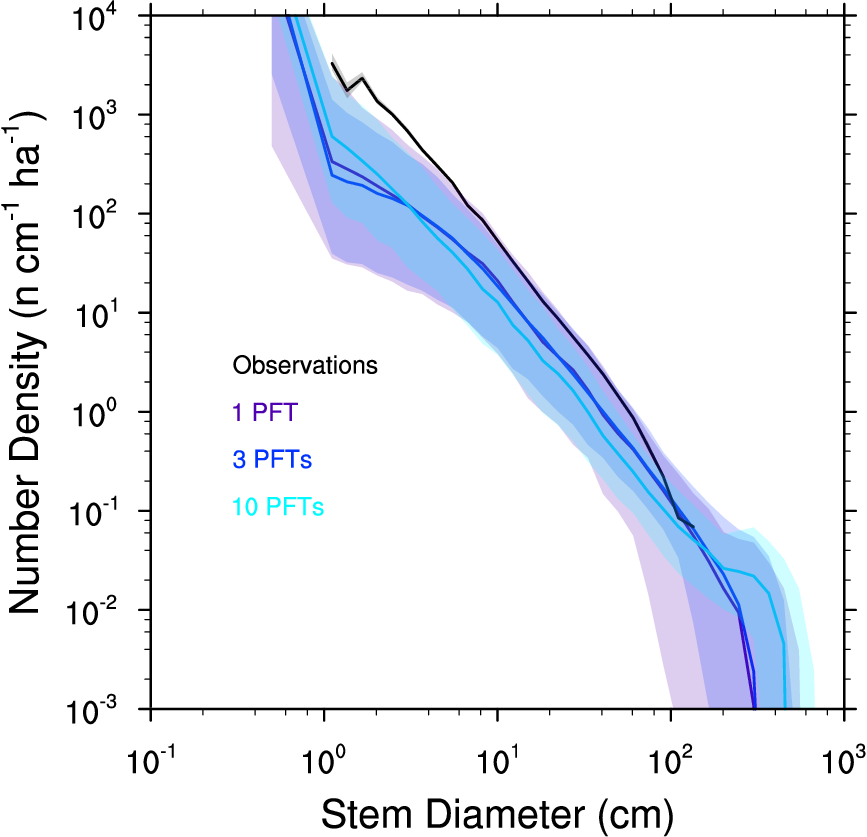

 
showing file sizedist_twoPFTs_struct_expt


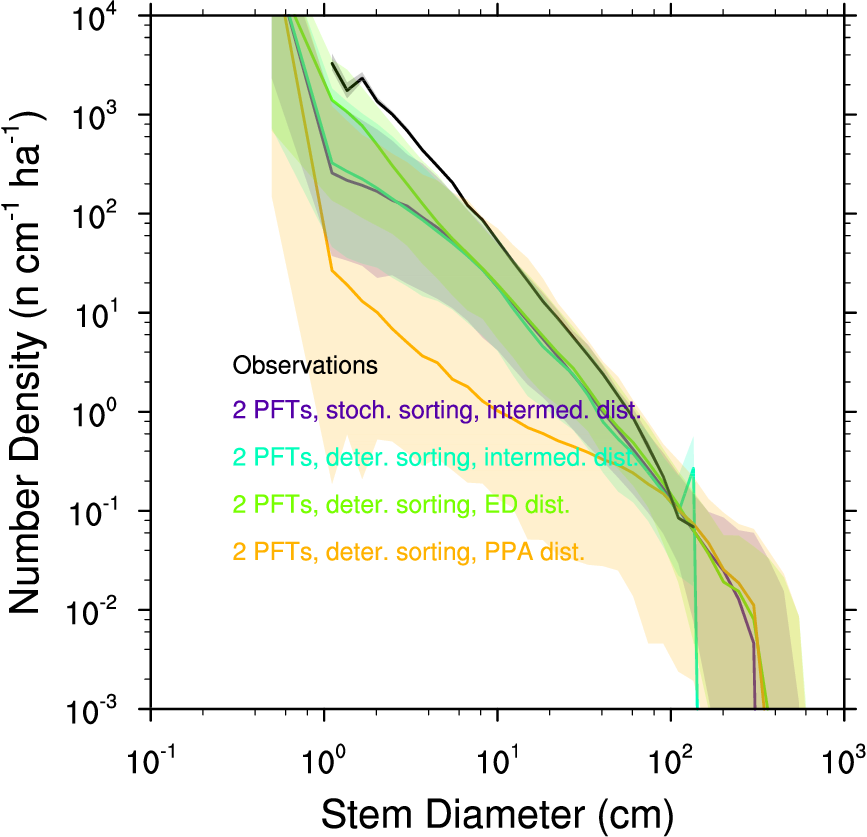

 
showing file sizedist_tenPFTs_recruit_expt


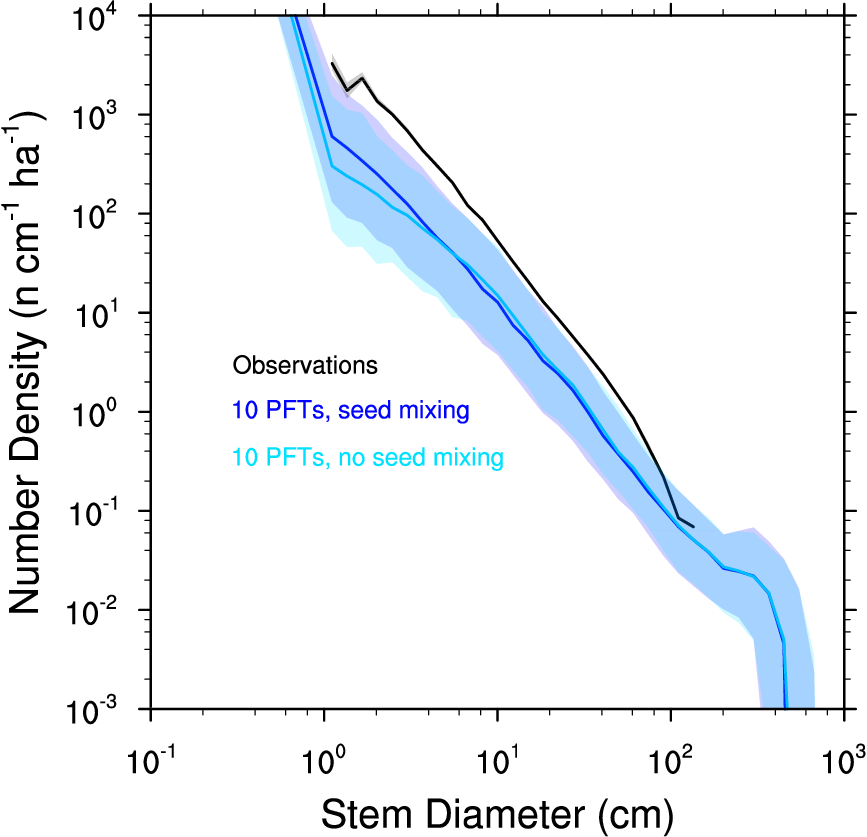

 
showing file sizedist_HLM_expt


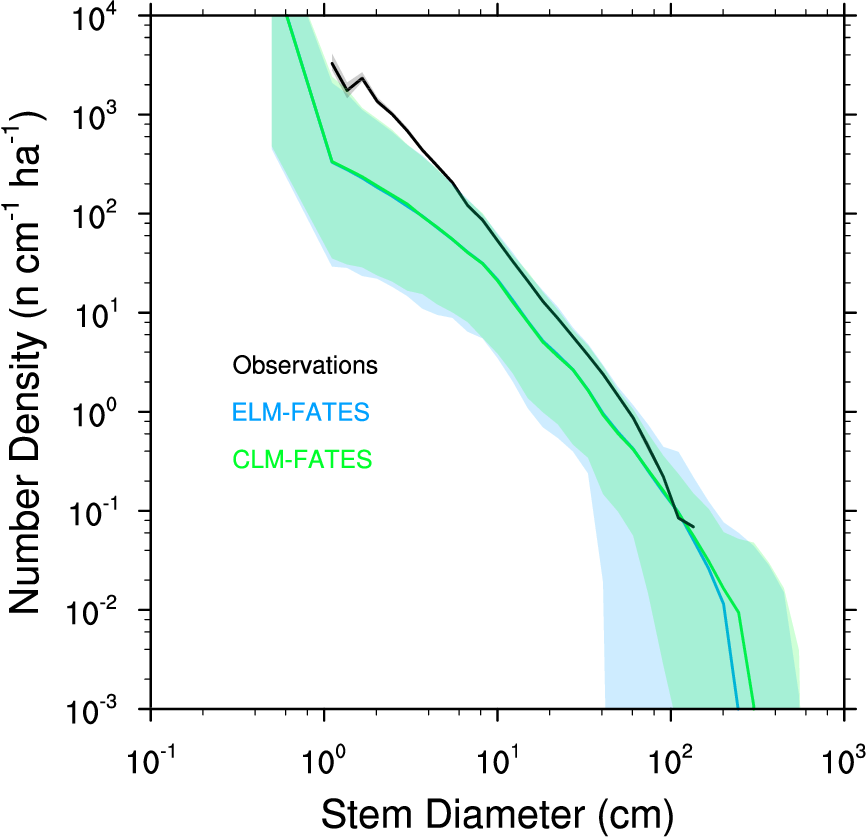

In [8]:
### plot the size distributions of each experiment as compared to the observed ones

for i in range(nexp):
    map_funcs.xyplot(levscls_mid, nplants_scls_allexps_percentiles[i,0:n_members_per_expt[i],1,:], xlog=True,ylog=True, yrange=[1e-3,1e4], labels=experiment_members_list_names[i], colors=colorlist[i], shadederror_ulimit=nplants_scls_allexps_percentiles[i,0:n_members_per_expt[i],2,:], shadederror_llimit=nplants_scls_allexps_percentiles[i,0:n_members_per_expt[i],0,:], shadederror_opacity=0.1, label_xstart=0.3, label_ystart=1, label_yspace=3., file='sizedist_'+experiment_list_shortnames[i], overlay_x=levscls_mid[1:nlevscls_obs+1], overlay_y=sizedist_inv_timeave, overlay_labels=['Observations'], overlay_shadederror_ulimit=sizedist_inv_max, overlay_shadederror_llimit=sizedist_inv_min, xtitle='Stem Diameter (cm)', ytitle='Number Density (n cm~S~-1~N~ ha~S~-1~N~)', overlaylabelystart=3., showjupyter=True)
    


 
showing file Ensemble_spread_variables


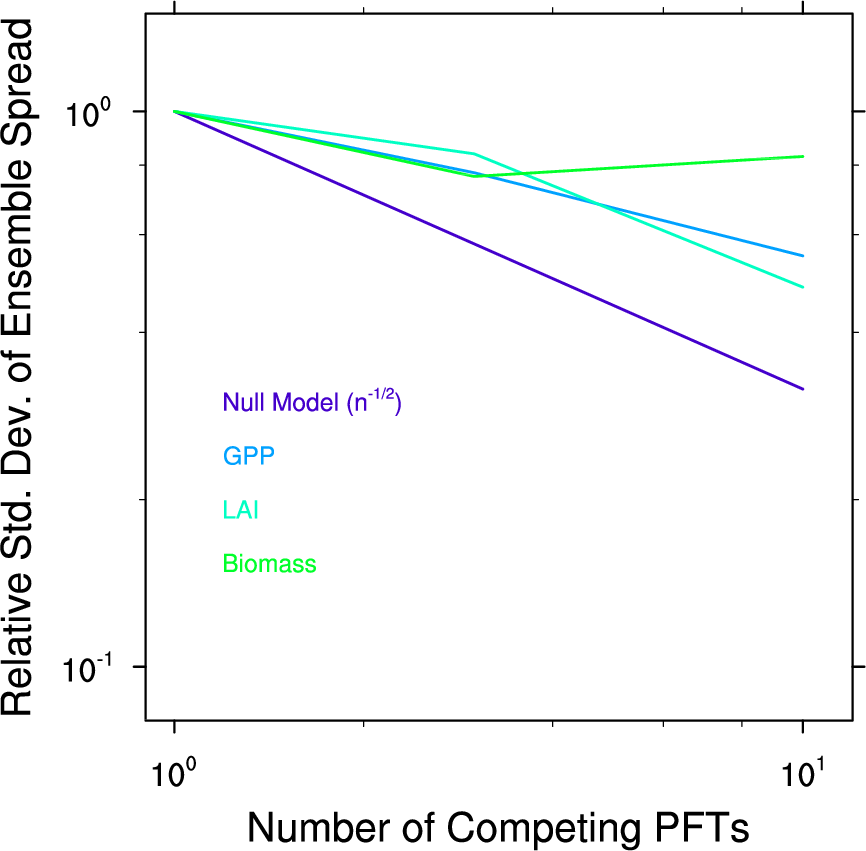

In [9]:
### now calculate the across-ensemble ensemble spread as a function of the number of PFTs for the NPFTs experiment
i_exp_npfts = 0
n_pft_exp_members = n_members_per_expt[i_exp_npfts]
npfts_n = np.array([1.,3.,10.])

vars_list = ['Null Model','GPP','LAI','Biomass']
nvars=len(vars_list)

stddev_vars_npfts = np.zeros([nvars,n_pft_exp_members])


for i in range(n_pft_exp_members):
    stddev_vars_npfts[0,i] = 1. / npfts_n[i]**0.5
    stddev_vars_npfts[1,i] = np.std(mean_gpp[i_exp_npfts,i,:]) / np.std(mean_gpp[i_exp_npfts,0,:])
    stddev_vars_npfts[2,i] = np.std(mean_lai[i_exp_npfts,i,:]) / np.std(mean_lai[i_exp_npfts,0,:])
    stddev_vars_npfts[3,i] = np.std(mean_biomass[i_exp_npfts,i,:]) / np.std(mean_biomass[i_exp_npfts,0,:])


map_funcs.xyplot(npfts_n,stddev_vars_npfts, xlog=True,ylog=True, colors=[10,50,75,100], labels=['Null Model (n~S~-1/2~N~)','GPP','LAI','Biomass'], xtitle='Number of Competing PFTs', ytitle='Relative Std. Dev. of Ensemble Spread', yrange=[0.08,1.5], xrange=[0.9,12.], label_ystart=0.3, label_yspace=1.25, label_xstart=1.2, file='Ensemble_spread_variables', showjupyter=True)


 
showing file rank_abundance_curves_10PFT_biomass


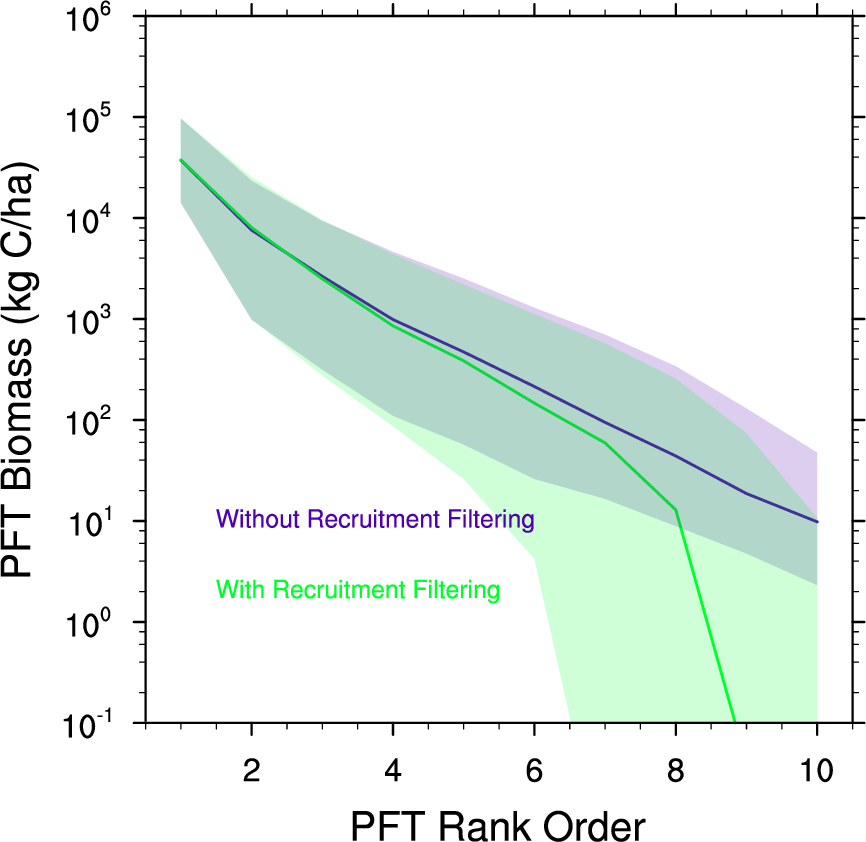

In [10]:
### for the 10 PFT simulations, calculate and plot rank abundance curves

# first plot biomass rank abundance curves

i_exp_recruitment = 2
n_recr_exp_members = n_members_per_expt[i_exp_recruitment]

minval_rankabundance=1e-20

pftabundance_biomass_mixing = np.sort(fates_history_files_h1[i_exp_recruitment][0].variables['PFTbiomass'][:,expt_mem_years[i][j][0]:expt_mem_years[i][j][1],:,0].mean(axis=1), axis=1)[:,::-1]
pftabundance_biomass_nomixing = np.sort(fates_history_files_h1[i_exp_recruitment][1].variables['PFTbiomass'][:,expt_mem_years[i][j][0]:expt_mem_years[i][j][1],:,0].mean(axis=1), axis=1)[:,::-1]

pftabundance_biomass_curves_mixing_percentiles = np.percentile(pftabundance_biomass_mixing[:,:], percentiles_toplot, axis=0)
pftabundance_biomass_curves_nomixing_percentiles = np.percentile(pftabundance_biomass_nomixing[:,:], percentiles_toplot, axis=0)

pftabundance_biomass_medians = np.maximum(np.row_stack([pftabundance_biomass_curves_mixing_percentiles[1,:],pftabundance_biomass_curves_nomixing_percentiles[1,:]]), minval_rankabundance)
pftabundance_biomass_ll = np.maximum(np.row_stack([pftabundance_biomass_curves_mixing_percentiles[0,:],pftabundance_biomass_curves_nomixing_percentiles[0,:]]), minval_rankabundance)
pftabundance_biomass_ul = np.maximum(np.row_stack([pftabundance_biomass_curves_mixing_percentiles[2,:],pftabundance_biomass_curves_nomixing_percentiles[2,:]]), minval_rankabundance)

map_funcs.xyplot(np.arange(10)+1, pftabundance_biomass_medians,ylog=True,yrange=[1e-1,1e6], xrange=[0.5,10.5], ytitle='PFT Biomass (kg C/ha)', xtitle='PFT Rank Order', colors=[5,100], labels=['Without Recruitment Filtering','With Recruitment Filtering'], label_yspace=5., label_ystart=1e1, shadederror_ulimit=pftabundance_biomass_ul, shadederror_llimit=pftabundance_biomass_ll, shadederror_opacity=0.1, file='rank_abundance_curves_10PFT_biomass', showjupyter=True)

#pftabundance_nomixing_masked = np.ma.masked_array(pftabundance_nomixing, mask=pftabundance_nomixing==0.)
#map_funcs.xyplot(np.arange(10), pftabundance_mixing, xlog=True,ylog=True,yrange=[1e-1,1e6], ytitle='PFT Biomass', xtitle='PFT Rank Order', title='Without Recruitment Filtering', file='pft_rankabundance_nofilter', linethickness=0.01)
#map_funcs.xyplot(np.arange(10), pftabundance_nomixing_masked, xlog=True,ylog=True,yrange=[1e-1,1e6], ytitle='PFT Biomass', xtitle='PFT Rank Order', title='With Recruitment Filtering', file='pft_rankabundance_yesfilter', linethickness=0.01)



 
showing file rank_abundance_curves_10PFT_crownarea


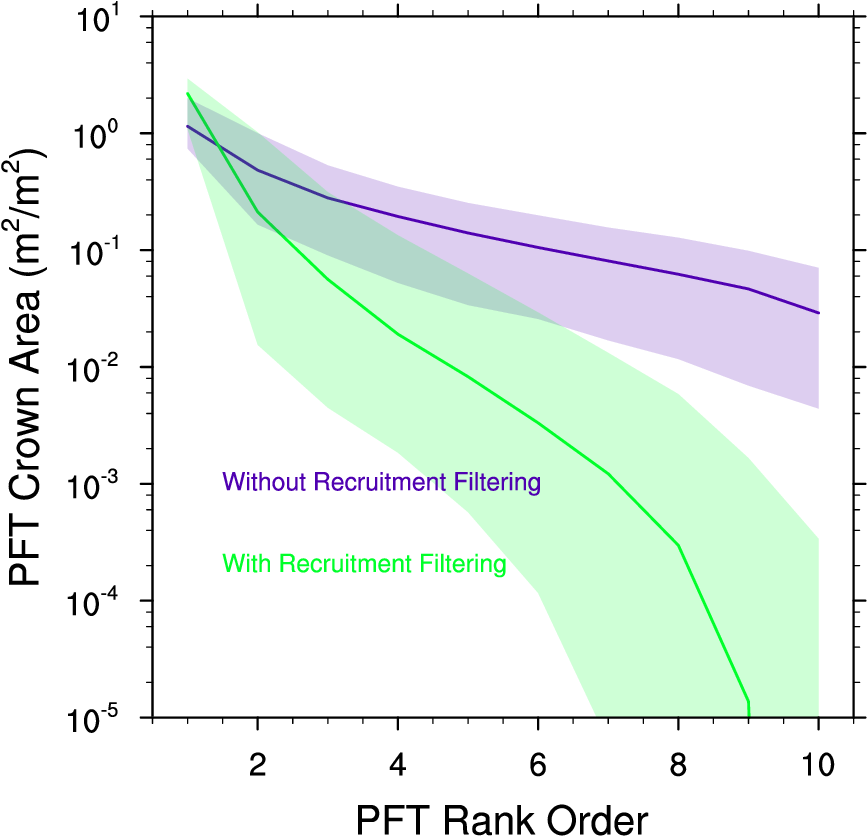

In [11]:
# plot total (canopy + understory) crown area rank abundance curves


pftabundance_crownarea_mixing = np.sort(fates_history_files_h1[i_exp_recruitment][0].variables['PFTcrownarea'][:,expt_mem_years[i][j][0]:expt_mem_years[i][j][1],:,0].mean(axis=1), axis=1)[:,::-1]
pftabundance_crownarea_nomixing = np.sort(fates_history_files_h1[i_exp_recruitment][1].variables['PFTcrownarea'][:,expt_mem_years[i][j][0]:expt_mem_years[i][j][1],:,0].mean(axis=1), axis=1)[:,::-1]

pftabundance_crownarea_curves_mixing_percentiles = np.percentile(pftabundance_crownarea_mixing[:,:], percentiles_toplot, axis=0)
pftabundance_crownarea_curves_nomixing_percentiles = np.percentile(pftabundance_crownarea_nomixing[:,:], percentiles_toplot, axis=0)

pftabundance_crownarea_medians = np.maximum(np.row_stack([pftabundance_crownarea_curves_mixing_percentiles[1,:],pftabundance_crownarea_curves_nomixing_percentiles[1,:]]), minval_rankabundance)
pftabundance_crownarea_ll = np.maximum(np.row_stack([pftabundance_crownarea_curves_mixing_percentiles[0,:],pftabundance_crownarea_curves_nomixing_percentiles[0,:]]), minval_rankabundance)
pftabundance_crownarea_ul = np.maximum(np.row_stack([pftabundance_crownarea_curves_mixing_percentiles[2,:],pftabundance_crownarea_curves_nomixing_percentiles[2,:]]), minval_rankabundance)

map_funcs.xyplot(np.arange(10)+1, pftabundance_crownarea_medians,ylog=True, xrange=[0.5,10.5], yrange=[1e-5,1e1], ytitle='PFT Crown Area (m~S~2~N~/m~S~2~N~)', xtitle='PFT Rank Order', colors=[5,100], labels=['Without Recruitment Filtering','With Recruitment Filtering'], label_yspace=5., label_ystart=1e-3, shadederror_ulimit=pftabundance_crownarea_ul, shadederror_llimit=pftabundance_crownarea_ll, shadederror_opacity=0.1, file='rank_abundance_curves_10PFT_crownarea', showjupyter=True)





 
showing file rank_abundance_curves_10PFT_canopycrownarea


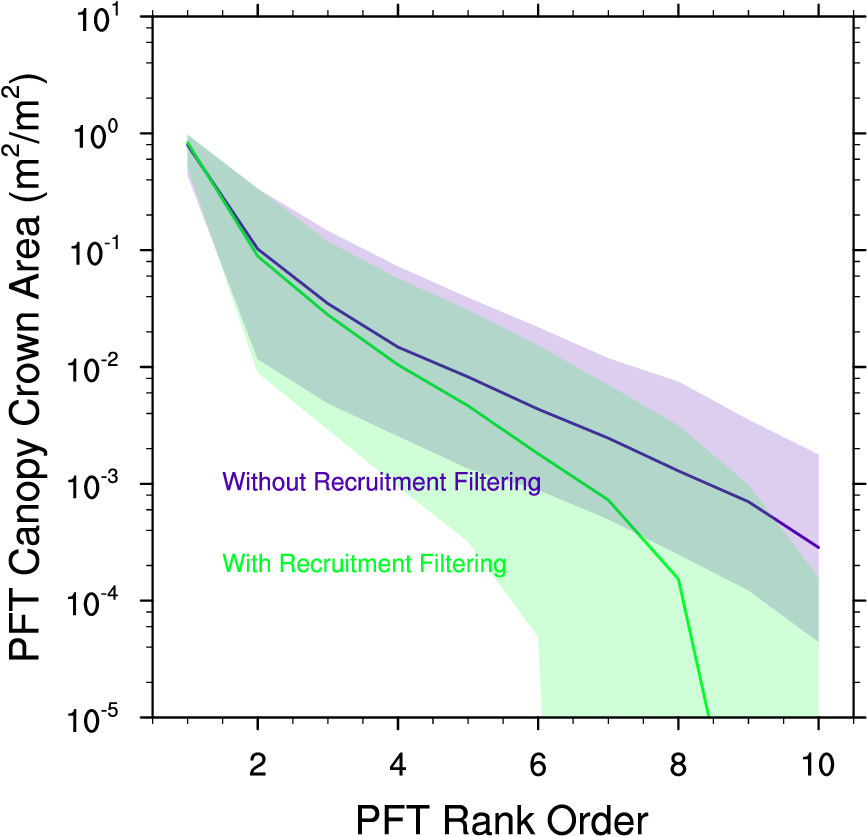

In [12]:
# plot canopy-only crown area rank abundance curves


pftabundance_canopycrownarea_mixing = np.sort(fates_history_files_h1[i_exp_recruitment][0].variables['PFTcanopycrownarea'][:,expt_mem_years[i][j][0]:expt_mem_years[i][j][1],:,0].mean(axis=1), axis=1)[:,::-1]
pftabundance_canopycrownarea_nomixing = np.sort(fates_history_files_h1[i_exp_recruitment][1].variables['PFTcanopycrownarea'][:,expt_mem_years[i][j][0]:expt_mem_years[i][j][1],:,0].mean(axis=1), axis=1)[:,::-1]

pftabundance_canopycrownarea_curves_mixing_percentiles = np.percentile(pftabundance_canopycrownarea_mixing[:,:], percentiles_toplot, axis=0)
pftabundance_canopycrownarea_curves_nomixing_percentiles = np.percentile(pftabundance_canopycrownarea_nomixing[:,:], percentiles_toplot, axis=0)

pftabundance_canopycrownarea_medians = np.maximum(np.row_stack([pftabundance_canopycrownarea_curves_mixing_percentiles[1,:],pftabundance_canopycrownarea_curves_nomixing_percentiles[1,:]]), minval_rankabundance)
pftabundance_canopycrownarea_ll = np.maximum(np.row_stack([pftabundance_canopycrownarea_curves_mixing_percentiles[0,:],pftabundance_canopycrownarea_curves_nomixing_percentiles[0,:]]), minval_rankabundance)
pftabundance_canopycrownarea_ul = np.maximum(np.row_stack([pftabundance_canopycrownarea_curves_mixing_percentiles[2,:],pftabundance_canopycrownarea_curves_nomixing_percentiles[2,:]]), minval_rankabundance)

map_funcs.xyplot(np.arange(10)+1, pftabundance_canopycrownarea_medians,ylog=True, xrange=[0.5,10.5], yrange=[1e-5,1e1], ytitle='PFT Canopy Crown Area (m~S~2~N~/m~S~2~N~)', xtitle='PFT Rank Order', colors=[5,100], labels=['Without Recruitment Filtering','With Recruitment Filtering'], label_yspace=5., label_ystart=1e-3, shadederror_ulimit=pftabundance_canopycrownarea_ul, shadederror_llimit=pftabundance_canopycrownarea_ll, shadederror_opacity=0.1, file='rank_abundance_curves_10PFT_canopycrownarea', showjupyter=True)




9.025033
 
showing file rank_abundance_curves_10PFT_populationgt10cm


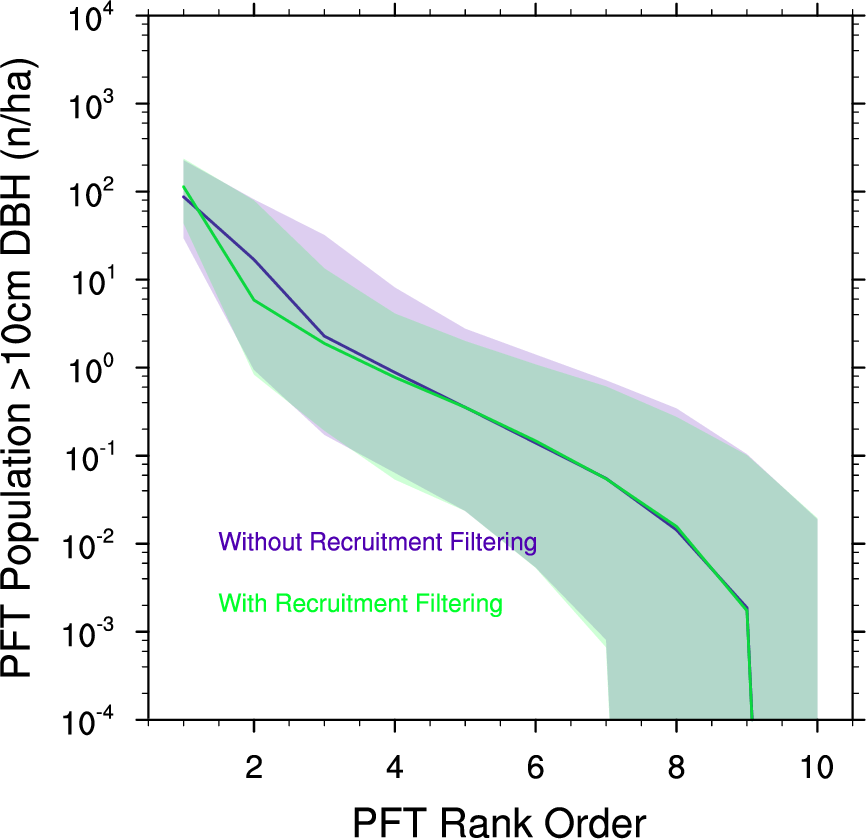

 
showing file rank_abundance_curves_10PFT_populationgt1cm


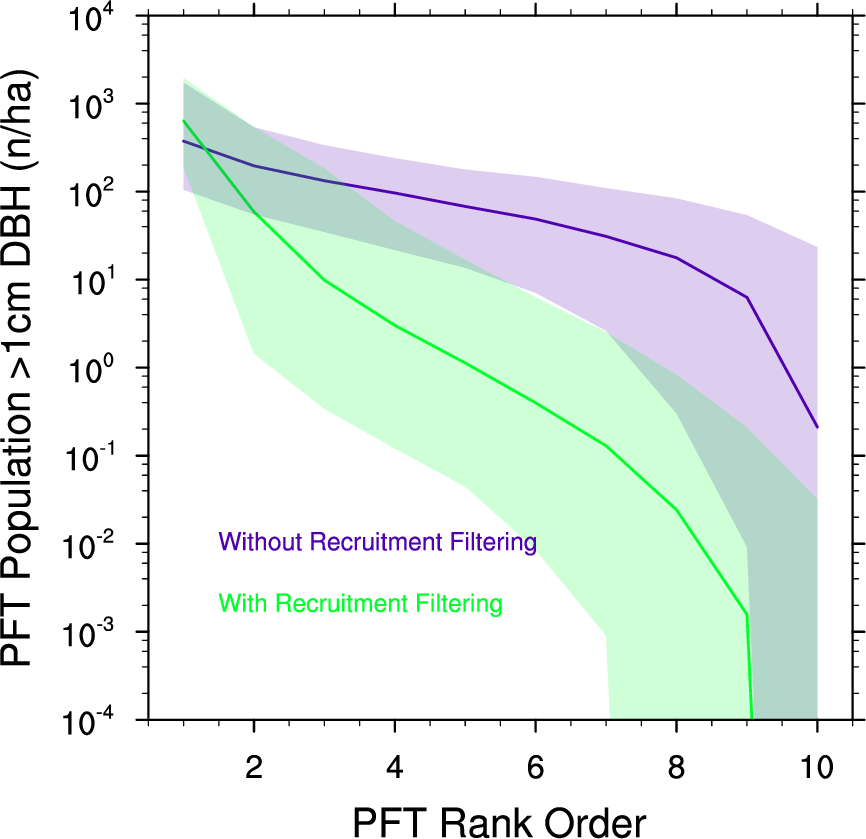

In [13]:
## and calculate a ranked abundanmce curve from actual population densities.  Lets use numbers greater than 1cm and 10cm here.  
## Because the lower bounds are at approximately 9 and 11 cm, estimate 10+cm population as 11+cm population + 0.5 * 9cm bin
ilevscls_9cm = 12
ilevscls_11cm = ilevscls_9cm+1
npfts_recrfiltexp = 10
print(fates_levscls[ilevscls_9cm])
nplant_scpf_mixing = fates_history_files_h1[i_exp_recruitment][0].variables['NPLANT_SCPF'][:,expt_mem_years[i][j][0]:expt_mem_years[i][j][1],:,0].mean(axis=1)
nplant_scpf_nomixing = fates_history_files_h1[i_exp_recruitment][1].variables['NPLANT_SCPF'][:,expt_mem_years[i][j][0]:expt_mem_years[i][j][1],:,0].mean(axis=1)

nplant_gt10cm_pft = np.ma.masked_all([n_recr_exp_members,n_ens_members,npfts_recrfiltexp])
nplant_scpf_mixing.shape
#nlevscls
for i_pft in range(npfts_recrfiltexp):
    nplant_gt10cm_pft[0,:,i_pft] = nplant_scpf_mixing[:,i_pft*nlevscls+ilevscls_11cm:(i_pft+1)*nlevscls].sum(axis=1)+0.5*nplant_scpf_mixing[:,i_pft*nlevscls+ilevscls_9cm]
    nplant_gt10cm_pft[1,:,i_pft] = nplant_scpf_nomixing[:,i_pft*nlevscls+ilevscls_11cm:(i_pft+1)*nlevscls].sum(axis=1)+0.5*nplant_scpf_mixing[:,i_pft*nlevscls+ilevscls_9cm]

nplant_gt10cm_pft = np.sort(nplant_gt10cm_pft, axis=2)[:,:,::-1]
    
pftabundance_populationgt10cm_curves_mixing_percentiles = np.percentile(nplant_gt10cm_pft[0,:,:], percentiles_toplot, axis=0)
pftabundance_populationgt10cm_curves_nomixing_percentiles = np.percentile(nplant_gt10cm_pft[1,:,:], percentiles_toplot, axis=0)

pftabundance_populationgt10cm_medians = np.maximum(np.row_stack([pftabundance_populationgt10cm_curves_mixing_percentiles[1,:],pftabundance_populationgt10cm_curves_nomixing_percentiles[1,:]]), minval_rankabundance)
pftabundance_populationgt10cm_ll = np.maximum(np.row_stack([pftabundance_populationgt10cm_curves_mixing_percentiles[0,:],pftabundance_populationgt10cm_curves_nomixing_percentiles[0,:]]), minval_rankabundance)
pftabundance_populationgt10cm_ul = np.maximum(np.row_stack([pftabundance_populationgt10cm_curves_mixing_percentiles[2,:],pftabundance_populationgt10cm_curves_nomixing_percentiles[2,:]]), minval_rankabundance)

map_funcs.xyplot(np.arange(10)+1, pftabundance_populationgt10cm_medians,ylog=True, xrange=[0.5,10.5], yrange=[1e-4,1e4], ytitle='PFT Population >10cm DBH (n/ha)', xtitle='PFT Rank Order', colors=[5,100], labels=['Without Recruitment Filtering','With Recruitment Filtering'], label_yspace=5., label_ystart=1e-2, shadederror_ulimit=pftabundance_populationgt10cm_ul, shadederror_llimit=pftabundance_populationgt10cm_ll, shadederror_opacity=0.1, file='rank_abundance_curves_10PFT_populationgt10cm', showjupyter=True)


ilevscls_1cm  = 1
nplant_gt1cm_pft = np.ma.masked_all([n_recr_exp_members,n_ens_members,npfts_recrfiltexp])

for i_pft in range(npfts_recrfiltexp):
    nplant_gt1cm_pft[0,:,i_pft] = nplant_scpf_mixing[:,i_pft*nlevscls+ilevscls_1cm:(i_pft+1)*nlevscls].sum(axis=1)
    nplant_gt1cm_pft[1,:,i_pft] = nplant_scpf_nomixing[:,i_pft*nlevscls+ilevscls_1cm:(i_pft+1)*nlevscls].sum(axis=1)

nplant_gt1cm_pft = np.sort(nplant_gt1cm_pft, axis=2)[:,:,::-1]
    
pftabundance_populationgt1cm_curves_mixing_percentiles = np.percentile(nplant_gt1cm_pft[0,:,:], percentiles_toplot, axis=0)
pftabundance_populationgt1cm_curves_nomixing_percentiles = np.percentile(nplant_gt1cm_pft[1,:,:], percentiles_toplot, axis=0)

pftabundance_populationgt1cm_medians = np.maximum(np.row_stack([pftabundance_populationgt1cm_curves_mixing_percentiles[1,:],pftabundance_populationgt1cm_curves_nomixing_percentiles[1,:]]), minval_rankabundance)
pftabundance_populationgt1cm_ll = np.maximum(np.row_stack([pftabundance_populationgt1cm_curves_mixing_percentiles[0,:],pftabundance_populationgt1cm_curves_nomixing_percentiles[0,:]]), minval_rankabundance)
pftabundance_populationgt1cm_ul = np.maximum(np.row_stack([pftabundance_populationgt1cm_curves_mixing_percentiles[2,:],pftabundance_populationgt1cm_curves_nomixing_percentiles[2,:]]), minval_rankabundance)

map_funcs.xyplot(np.arange(10)+1, pftabundance_populationgt1cm_medians,ylog=True, xrange=[0.5,10.5], yrange=[1e-4,1e4], ytitle='PFT Population >1cm DBH (n/ha)', xtitle='PFT Rank Order', colors=[5,100], labels=['Without Recruitment Filtering','With Recruitment Filtering'], label_yspace=5., label_ystart=1e-2, shadederror_ulimit=pftabundance_populationgt1cm_ul, shadederror_llimit=pftabundance_populationgt1cm_ll, shadederror_opacity=0.1, file='rank_abundance_curves_10PFT_populationgt1cm', showjupyter=True)





In [14]:
## plot the competition dynamics in the 2 PFT cases
i_exp_2pfts = 1
i_expmem_stochsort = 0
n_2pft_exp_members = n_members_per_expt[i_exp_2pfts]

refsize_lower = 15.
lev_refsize_lower = np.argmin(np.abs(levscls_mid - refsize_lower))

refsize_upper = 30.
lev_refsize_upper = np.argmin(np.abs(levscls_mid - refsize_upper))

year_rates_start = 5
year_rates_end = 25

growth_rate_canopy_pft1 = fates_history_files_h1[i_exp_2pfts][i_expmem_stochsort].variables['DDBH_CANOPY_SCPF'][:,year_rates_start:year_rates_end,lev_refsize_lower:lev_refsize_upper,0].mean(axis=1).sum(axis=1)/fates_history_files_h1[i_exp_2pfts][i_expmem_stochsort].variables['NPLANT_CANOPY_SCPF'][:,year_rates_start:year_rates_end,lev_refsize_lower:lev_refsize_upper,0].mean(axis=1).sum(axis=1)
growth_rate_canopy_pft2 = fates_history_files_h1[i_exp_2pfts][i_expmem_stochsort].variables['DDBH_CANOPY_SCPF'][:,year_rates_start:year_rates_end,lev_refsize_lower+nlevscls:lev_refsize_upper+nlevscls,0].mean(axis=1).sum(axis=1)/fates_history_files_h1[i_exp_2pfts][i_expmem_stochsort].variables['NPLANT_CANOPY_SCPF'][:,year_rates_start:year_rates_end,lev_refsize_lower+nlevscls:lev_refsize_upper+nlevscls,0].mean(axis=1).sum(axis=1)

mort_rate_canopy_pft1 = fates_history_files_h1[i_exp_2pfts][i_expmem_stochsort].variables['MORTALITY_CANOPY_SCPF'][:,year_rates_start:year_rates_end,lev_refsize_lower:lev_refsize_upper,0].mean(axis=1).sum(axis=1)/fates_history_files_h1[i_exp_2pfts][i_expmem_stochsort].variables['NPLANT_CANOPY_SCPF'][:,year_rates_start:year_rates_end,lev_refsize_lower:lev_refsize_upper,0].mean(axis=1).sum(axis=1)
mort_rate_canopy_pft2 = fates_history_files_h1[i_exp_2pfts][i_expmem_stochsort].variables['MORTALITY_CANOPY_SCPF'][:,year_rates_start:year_rates_end,lev_refsize_lower+nlevscls:lev_refsize_upper+nlevscls,0].mean(axis=1).sum(axis=1)/fates_history_files_h1[i_exp_2pfts][i_expmem_stochsort].variables['NPLANT_CANOPY_SCPF'][:,year_rates_start:year_rates_end,lev_refsize_lower+nlevscls:lev_refsize_upper+nlevscls,0].mean(axis=1).sum(axis=1)

growth_rate_understory_pft1 = fates_history_files_h1[i_exp_2pfts][i_expmem_stochsort].variables['DDBH_UNDERSTORY_SCPF'][:,year_rates_start:year_rates_end,lev_refsize_lower:lev_refsize_upper,0].mean(axis=1).sum(axis=1)/fates_history_files_h1[i_exp_2pfts][i_expmem_stochsort].variables['NPLANT_UNDERSTORY_SCPF'][:,year_rates_start:year_rates_end,lev_refsize_lower:lev_refsize_upper,0].mean(axis=1).sum(axis=1)
growth_rate_understory_pft2 = fates_history_files_h1[i_exp_2pfts][i_expmem_stochsort].variables['DDBH_UNDERSTORY_SCPF'][:,year_rates_start:year_rates_end,lev_refsize_lower+nlevscls:lev_refsize_upper+nlevscls,0].mean(axis=1).sum(axis=1)/fates_history_files_h1[i_exp_2pfts][i_expmem_stochsort].variables['NPLANT_UNDERSTORY_SCPF'][:,year_rates_start:year_rates_end,lev_refsize_lower+nlevscls:lev_refsize_upper+nlevscls,0].mean(axis=1).sum(axis=1)

mort_rate_understory_pft1 = fates_history_files_h1[i_exp_2pfts][i_expmem_stochsort].variables['MORTALITY_UNDERSTORY_SCPF'][:,year_rates_start:year_rates_end,lev_refsize_lower:lev_refsize_upper,0].mean(axis=1).sum(axis=1)/fates_history_files_h1[i_exp_2pfts][i_expmem_stochsort].variables['NPLANT_UNDERSTORY_SCPF'][:,year_rates_start:year_rates_end,lev_refsize_lower:lev_refsize_upper,0].mean(axis=1).sum(axis=1)
mort_rate_understory_pft2 = fates_history_files_h1[i_exp_2pfts][i_expmem_stochsort].variables['MORTALITY_UNDERSTORY_SCPF'][:,year_rates_start:year_rates_end,lev_refsize_lower+nlevscls:lev_refsize_upper+nlevscls,0].mean(axis=1).sum(axis=1)/fates_history_files_h1[i_exp_2pfts][i_expmem_stochsort].variables['NPLANT_UNDERSTORY_SCPF'][:,year_rates_start:year_rates_end,lev_refsize_lower+nlevscls:lev_refsize_upper+nlevscls,0].mean(axis=1).sum(axis=1)



In [15]:
## also calculate recruitment per unit canopy crown area for each PFT
recruitment_rate_pft1 = (fates_history_files_h1[i_exp_2pfts][i_expmem_stochsort].variables['RECRUITMENT'][:,year_rates_start:year_rates_end,0,0] / fates_history_files_h1[i_exp_2pfts][i_expmem_stochsort].variables['PFTcanopycrownarea'][:,year_rates_start:year_rates_end,0,0]).mean(axis=1) 
recruitment_rate_pft2 = (fates_history_files_h1[i_exp_2pfts][i_expmem_stochsort].variables['RECRUITMENT'][:,year_rates_start:year_rates_end,1,0] / fates_history_files_h1[i_exp_2pfts][i_expmem_stochsort].variables['PFTcanopycrownarea'][:,year_rates_start:year_rates_end,1,0]).mean(axis=1) 

 
showing file histogram_growthrate_canopy_2pfts


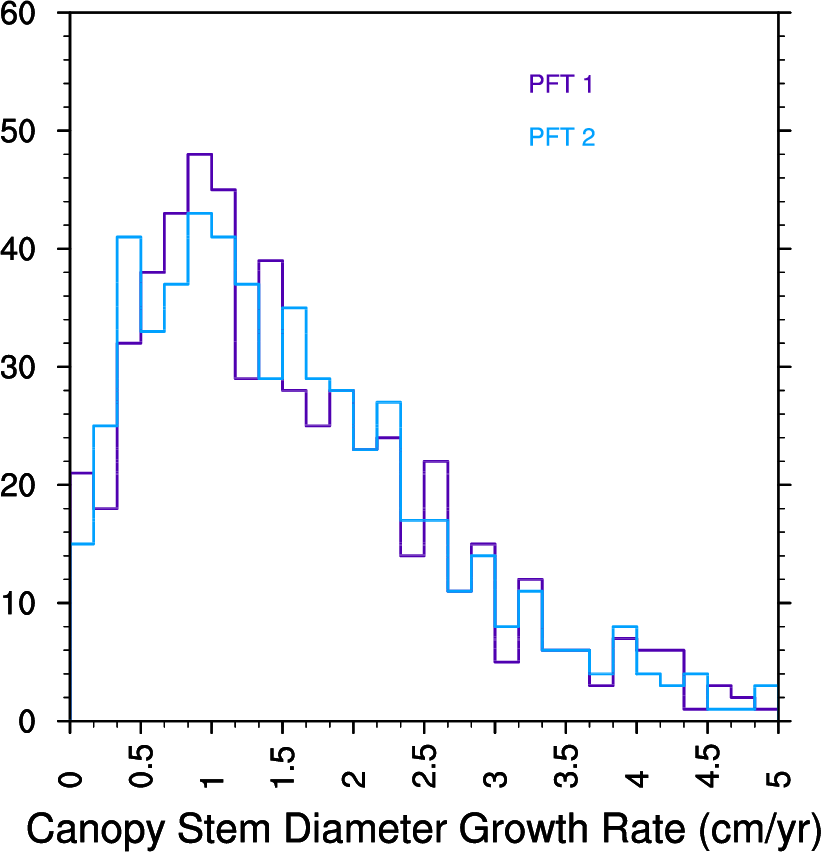

 
showing file histogram_growthrate_understory_2pfts


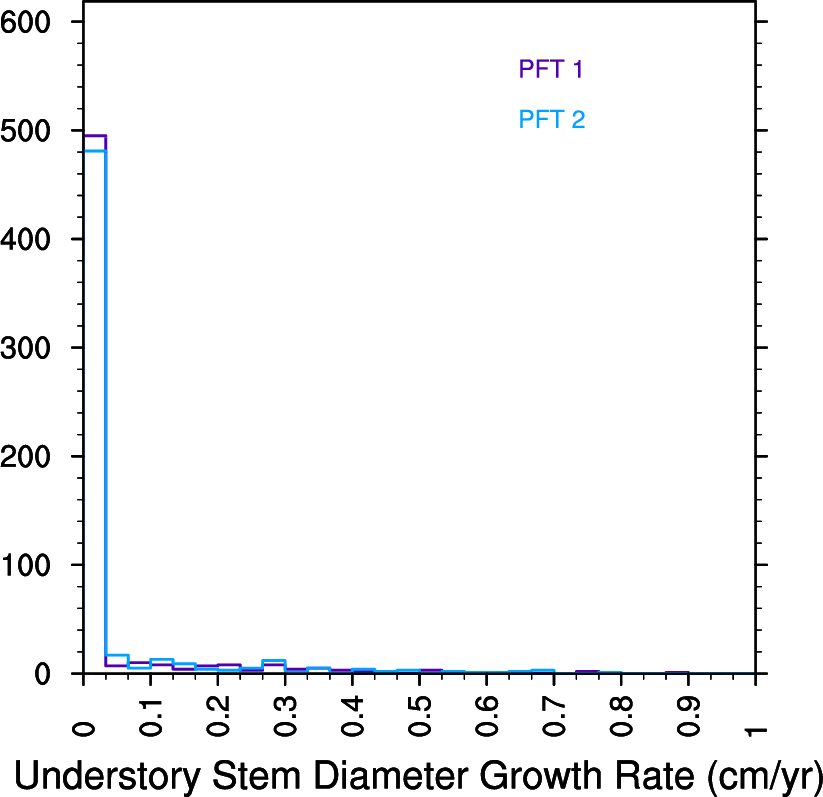

 
showing file histogram_mortrate_canopy_2pfts


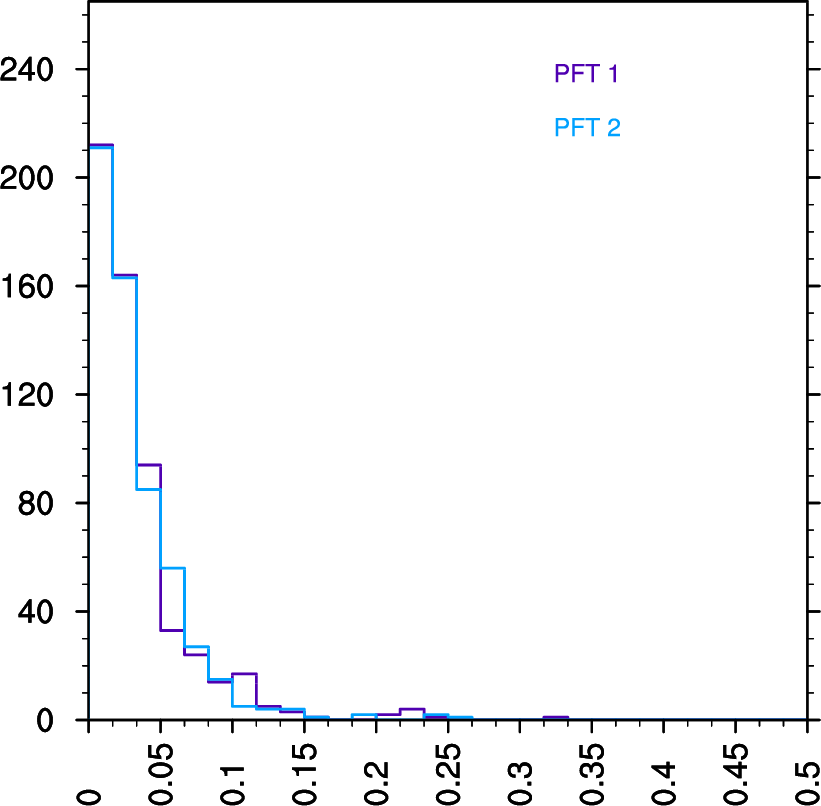

 
showing file histogram_mortrate_understory_2pfts


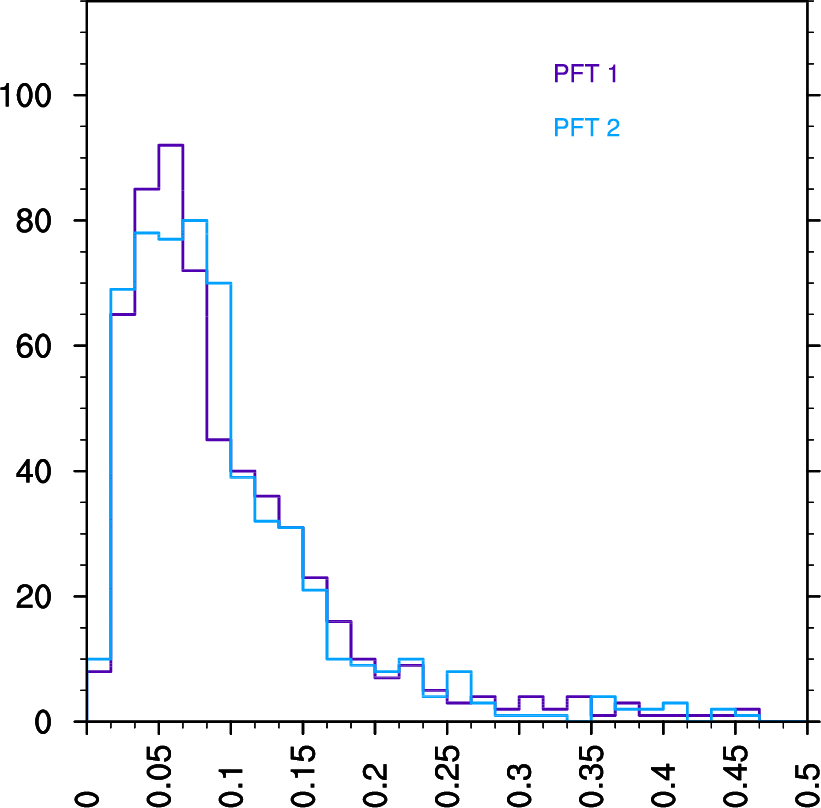

In [16]:
## plot histograms of growth and mortality rates in canopy and understory

map_funcs.plot_histogram(np.row_stack([growth_rate_canopy_pft1,growth_rate_canopy_pft2]),bins=30, therange=[0.,5.], file='histogram_growthrate_canopy_2pfts', labels=['PFT 1','PFT 2'], colors=[5,50], axis=0, xtitle='Canopy Stem Diameter Growth Rate (cm/yr)', showjupyter=True)
map_funcs.plot_histogram(np.row_stack([growth_rate_understory_pft1,growth_rate_understory_pft2]),bins=30, therange=[0.,1.], file='histogram_growthrate_understory_2pfts', labels=['PFT 1','PFT 2'], colors=[5,50], axis=0, xtitle='Understory Stem Diameter Growth Rate (cm/yr)', showjupyter=True)

map_funcs.plot_histogram(np.row_stack([mort_rate_canopy_pft1,mort_rate_canopy_pft2]),bins=30, therange=[0.,0.5], file='histogram_mortrate_canopy_2pfts', labels=['PFT 1','PFT 2'], colors=[5,50], axis=0, showjupyter=True)
map_funcs.plot_histogram(np.row_stack([mort_rate_understory_pft1,mort_rate_understory_pft2]),bins=30, therange=[0.,0.5], file='histogram_mortrate_understory_2pfts', labels=['PFT 1','PFT 2'], colors=[5,50], axis=0, showjupyter=True)


In [17]:
### loop through 2-PFT experiments, and calculate the fraction of biomass, canopy area, and crown canopy area in the first PFT for each experiment
frac_biomass_pft1 = np.ma.masked_all([n_2pft_exp_members,n_ens_members])
frac_crownarea_pft1 = np.ma.masked_all([n_2pft_exp_members,n_ens_members])
frac_canopycrownarea_pft1 = np.ma.masked_all([n_2pft_exp_members,n_ens_members])

for i in range(n_2pft_exp_members):
    pftbiomass = fates_history_files_h1[i_exp_2pfts][i].variables['PFTbiomass'][:,expt_mem_years[i_exp_2pfts][i][0]:expt_mem_years[i_exp_2pfts][i][1],:,0].mean(axis=1)
    frac_biomass_pft1[i,:] = pftbiomass[:,0] / pftbiomass.sum(axis=1)
    try:
        pftcrownarea = fates_history_files_h1[i_exp_2pfts][i].variables['PFTcrownarea'][:,expt_mem_years[i_exp_2pfts][i][0]:expt_mem_years[i_exp_2pfts][i][1],:,0].mean(axis=1)
        frac_crownarea_pft1[i,:] = pftcrownarea[:,0] / pftcrownarea.sum(axis=1)
    except:
        print('no crown area ' + str(i))
    try:
        pftcanopycrownarea = fates_history_files_h1[i_exp_2pfts][i].variables['PFTcanopycrownarea'][:,expt_mem_years[i_exp_2pfts][i][0]:expt_mem_years[i_exp_2pfts][i][1],:,0].mean(axis=1)
        frac_canopycrownarea_pft1[i,:] = pftcanopycrownarea[:,0] / pftcanopycrownarea.sum(axis=1)
    except:
        print('no canopy crown area ' + str(i))

no crown area 1
no canopy crown area 1


In [18]:
competitiveness_index1 = np.ma.masked_all([n_ens_members])
frac_biomass_early_pft_index1 = np.ma.masked_all([n_2pft_exp_members,n_ens_members])
logratio_recruitment_early_over_late = np.ma.masked_all([n_ens_members])
logratio_undmort_early_over_late = np.ma.masked_all([n_ens_members])

earlylate_index1 = np.zeros(n_ens_members, dtype=np.bool)

frac_biomass_superior_pft_index1 = np.ma.masked_all([n_2pft_exp_members,n_ens_members])

for i in range(n_ens_members):
    slope = (growth_rate_canopy_pft1[i] - growth_rate_canopy_pft2[i])/(mort_rate_canopy_pft1[i]-mort_rate_canopy_pft2[i])
    if slope > 0.:
        ### in this case, we have an early vs late succesional type tradeoff.  i.e. faster growth and also faster mortality of one of the PFTs
        competitiveness_index1[i] = np.log10(slope)
        earlylate_index1[i] = True
        if (growth_rate_canopy_pft1[i] - growth_rate_canopy_pft2[i]) > 0.:
            frac_biomass_early_pft_index1[:,i] = frac_biomass_pft1[:,i]
            logratio_recruitment_early_over_late[i] = np.log10(recruitment_rate_pft1[i] / recruitment_rate_pft2[i])
            logratio_undmort_early_over_late[i] = np.log10(mort_rate_understory_pft1[i] / mort_rate_understory_pft2[i])
        else:
            frac_biomass_early_pft_index1[:,i] = 1. - frac_biomass_pft1[:,i]
            logratio_recruitment_early_over_late[i] = np.log10(recruitment_rate_pft2[i] / recruitment_rate_pft1[i])
            logratio_undmort_early_over_late[i] = np.log10(mort_rate_understory_pft2[i] / mort_rate_understory_pft1[i])
    else:
        ### in this case, we likely have a superior/inferior competitor.  i.e the PFT that both grows faster and dies slower should dominate
        if (growth_rate_canopy_pft1[i] - growth_rate_canopy_pft2[i]) > 0.:
            frac_biomass_superior_pft_index1[:,i] = frac_biomass_pft1[:,i]
        else:
            frac_biomass_superior_pft_index1[:,i] = 1.-frac_biomass_pft1[:,i]


In [19]:
competitiveness_index2 = np.ma.masked_all([n_ens_members])
frac_biomass_early_pft_index2 = np.ma.masked_all([n_2pft_exp_members,n_ens_members])

earlylate_index2 = np.zeros(n_ens_members, dtype=np.bool)

frac_biomass_superior_pft_index2 = np.ma.masked_all([n_2pft_exp_members,n_ens_members])

for i in range(n_ens_members):
    slope = (growth_rate_canopy_pft1[i] - growth_rate_canopy_pft2[i])/(mort_rate_understory_pft1[i]-mort_rate_understory_pft2[i])
    if slope > 0.:
        ### in this case, we have an early vs late succesional type tradeoff.  i.e. faster growth and also faster mortality of one of the PFTs
        competitiveness_index2[i] = np.log10(slope)
        earlylate_index2[i] = True
        if (growth_rate_canopy_pft2[i] - growth_rate_canopy_pft2[i]) > 0.:
            frac_biomass_early_pft_index2[:,i] = frac_biomass_pft1[:,i]
        else:
            frac_biomass_early_pft_index2[:,i] = 1. - frac_biomass_pft1[:,i]
    else:
        ### in this case, we likely have a superior/inferior competitor.  i.e the PFT that both grows faster and dies slower should dominate
        if (growth_rate_canopy_pft1[i] - growth_rate_canopy_pft2[i]) > 0.:
            frac_biomass_superior_pft_index2[:,i] = frac_biomass_pft1[:,i]
        else:
            frac_biomass_superior_pft_index2[:,i] = 1.-frac_biomass_pft1[:,i]

 
showing file EarlyLate_PFTbiomassfrac_cangrowthcanmort_coloredbyrecruitment_exp0


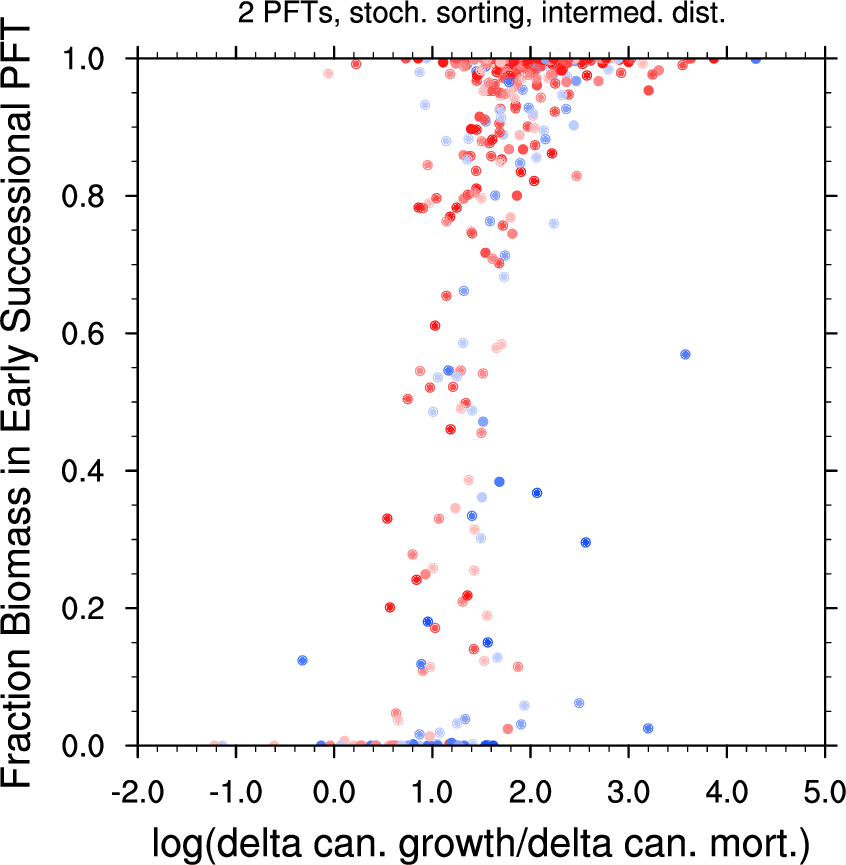

 
showing file EarlyLate_PFTbiomassfrac_cangrowthcanmort_coloredbyrecruitment_exp1


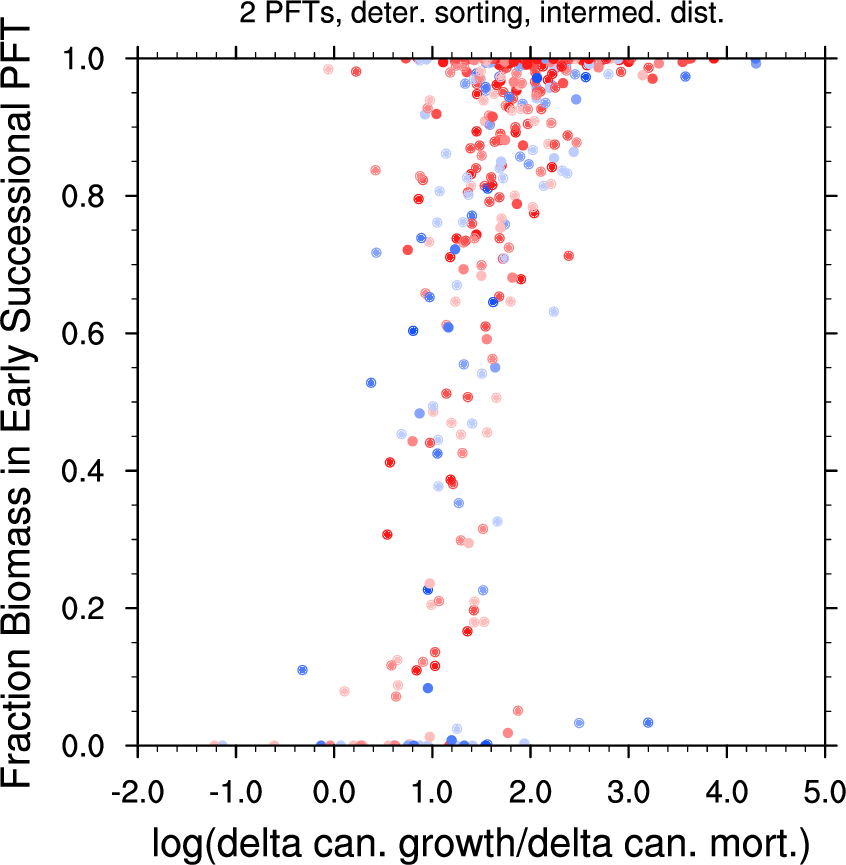

 
showing file EarlyLate_PFTbiomassfrac_cangrowthcanmort_coloredbyrecruitment_exp2


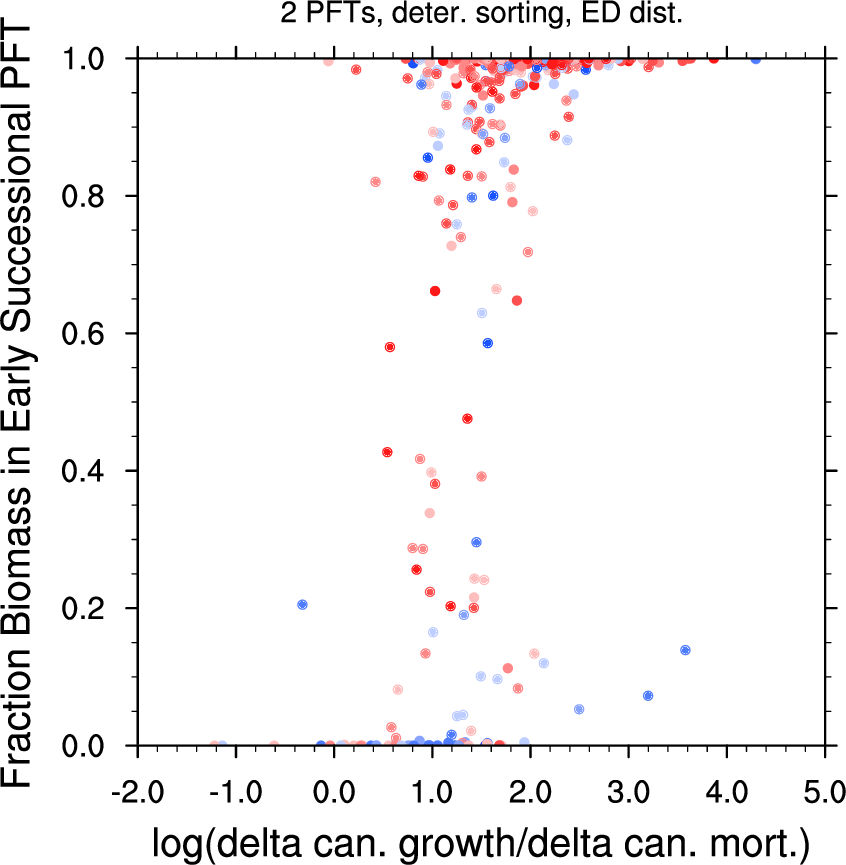

 
showing file EarlyLate_PFTbiomassfrac_cangrowthcanmort_coloredbyrecruitment_exp3


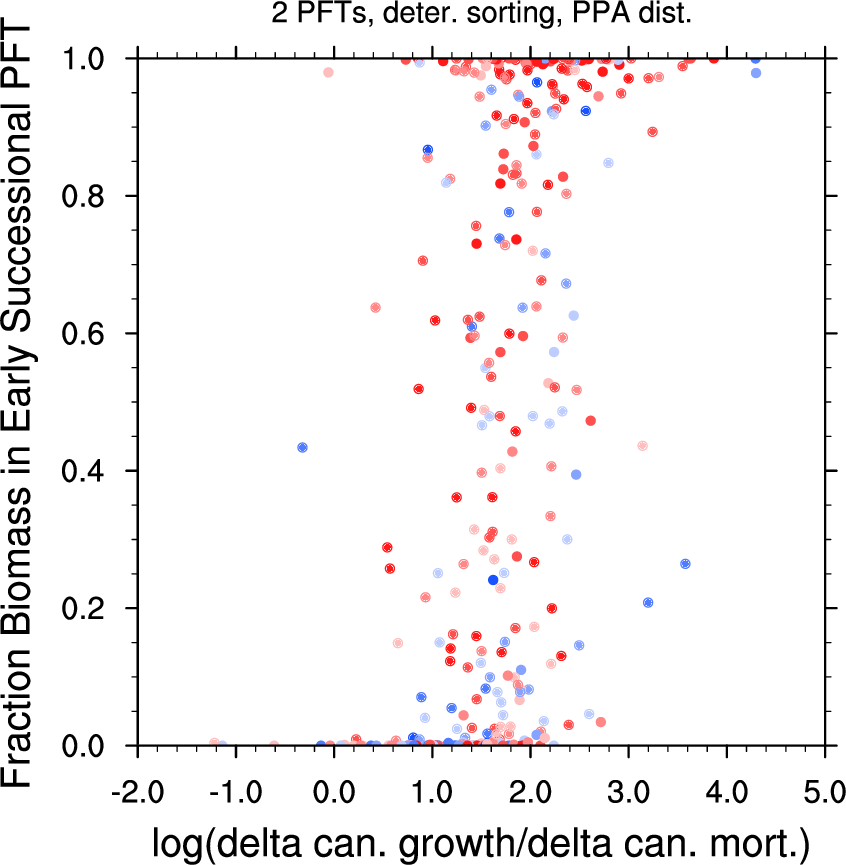

In [20]:
### try coloring the dots in the canopy index by (a) understory mortality rate difference, and (b) recruitment rate difference
for i in range(n_2pft_exp_members):
    map_funcs.xyplot(competitiveness_index1, frac_biomass_early_pft_index1[i,:], dots=True, xtitle='log(delta can. growth/delta can. mort.)', ytitle='Fraction Biomass in Early Successional PFT', title=experiment_members_list_names[i_exp_2pfts][i], file='EarlyLate_PFTbiomassfrac_cangrowthcanmort_coloredbyrecruitment_exp'+str(i), shaded_dot_data=logratio_recruitment_early_over_late, shaded_dot_levels=[-1,-0.5,-0.25,0,0.25,0.5,1], yrange=[0.,1.], xrange=[-2,5], colormap='BlueRed', showjupyter=True)


 
showing file EarlyLate_PFTbiomassfrac_cangrowthcanmort_coloredbyunderstorymort_exp0


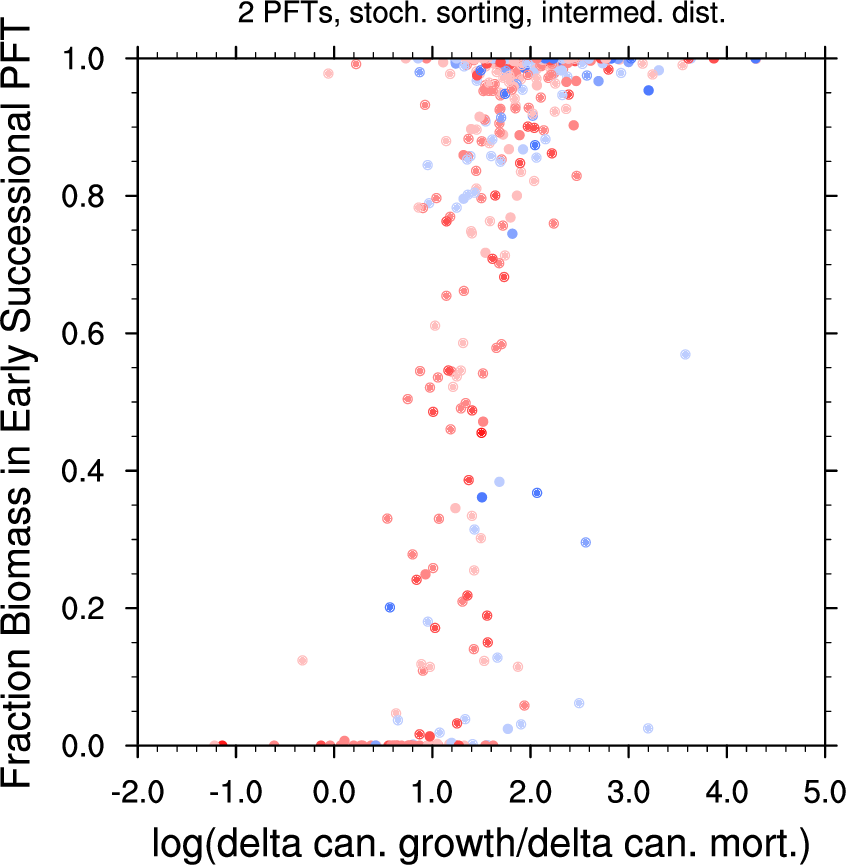

 
showing file EarlyLate_PFTbiomassfrac_cangrowthcanmort_coloredbyunderstorymort_exp1


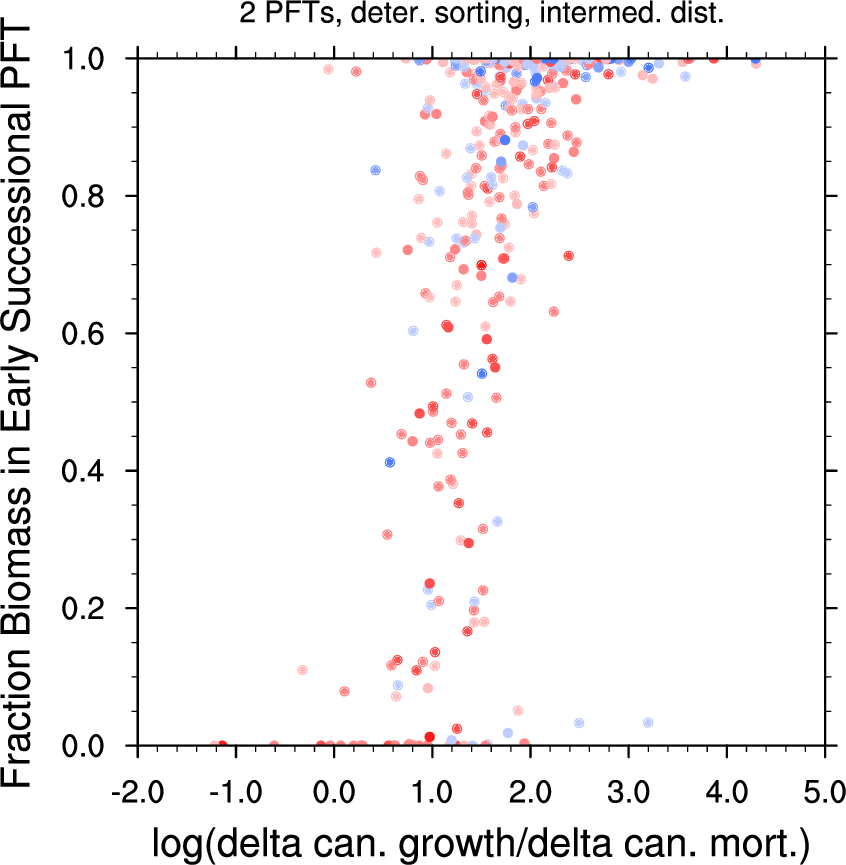

 
showing file EarlyLate_PFTbiomassfrac_cangrowthcanmort_coloredbyunderstorymort_exp2


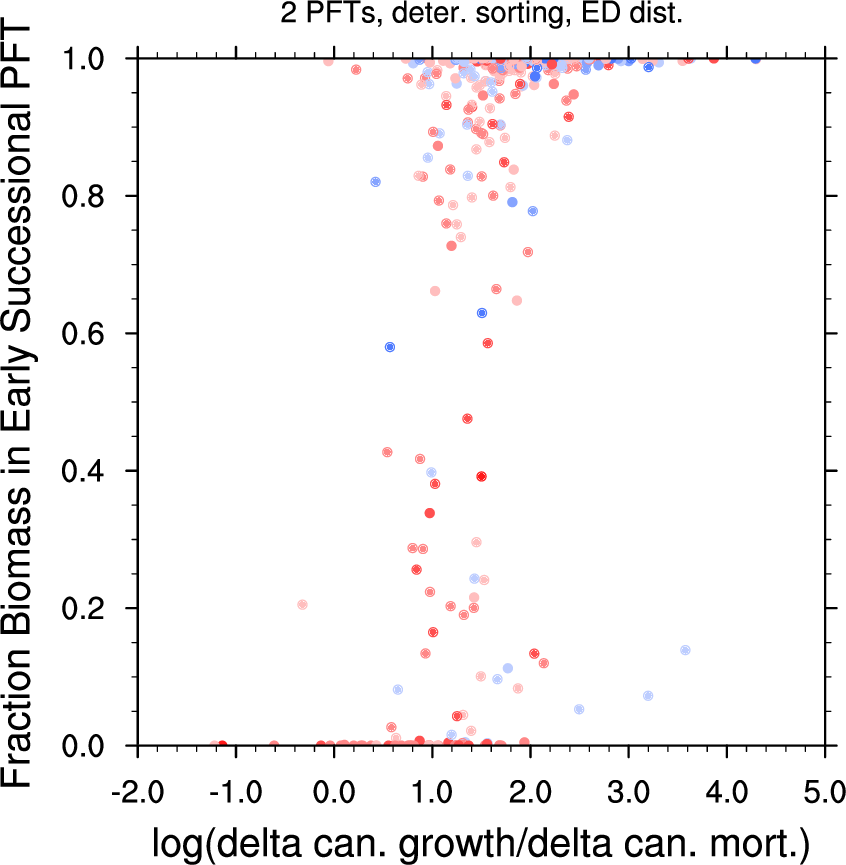

 
showing file EarlyLate_PFTbiomassfrac_cangrowthcanmort_coloredbyunderstorymort_exp3


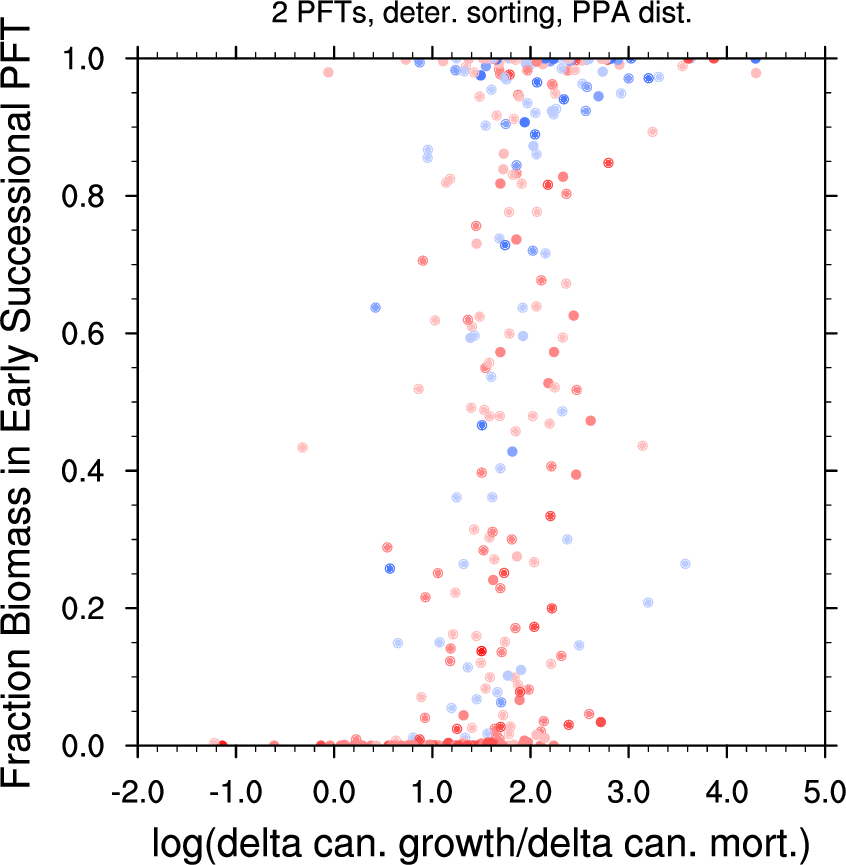

In [21]:
### try coloring the dots in the canopy index by (a) understory mortality rate difference, and (b) recruitment rate difference
for i in range(n_2pft_exp_members):
    map_funcs.xyplot(competitiveness_index1, frac_biomass_early_pft_index1[i,:], dots=True, xtitle='log(delta can. growth/delta can. mort.)', ytitle='Fraction Biomass in Early Successional PFT', title=experiment_members_list_names[i_exp_2pfts][i], file='EarlyLate_PFTbiomassfrac_cangrowthcanmort_coloredbyunderstorymort_exp'+str(i), shaded_dot_data=logratio_undmort_early_over_late, shaded_dot_levels=[-1,-0.5,-0.25,0,0.25,0.5,1], yrange=[0.,1.], xrange=[-2,5], colormap='BlueRed', showjupyter=True)



In [22]:
def logisticfunc(x, k, xnaught):
    y = 1./(1.+np.exp(-k*(x-xnaught)))
    return y

 
showing file EarlyLate_PFTbiomassfrac_cangrowthcanmort_withregression_exp0


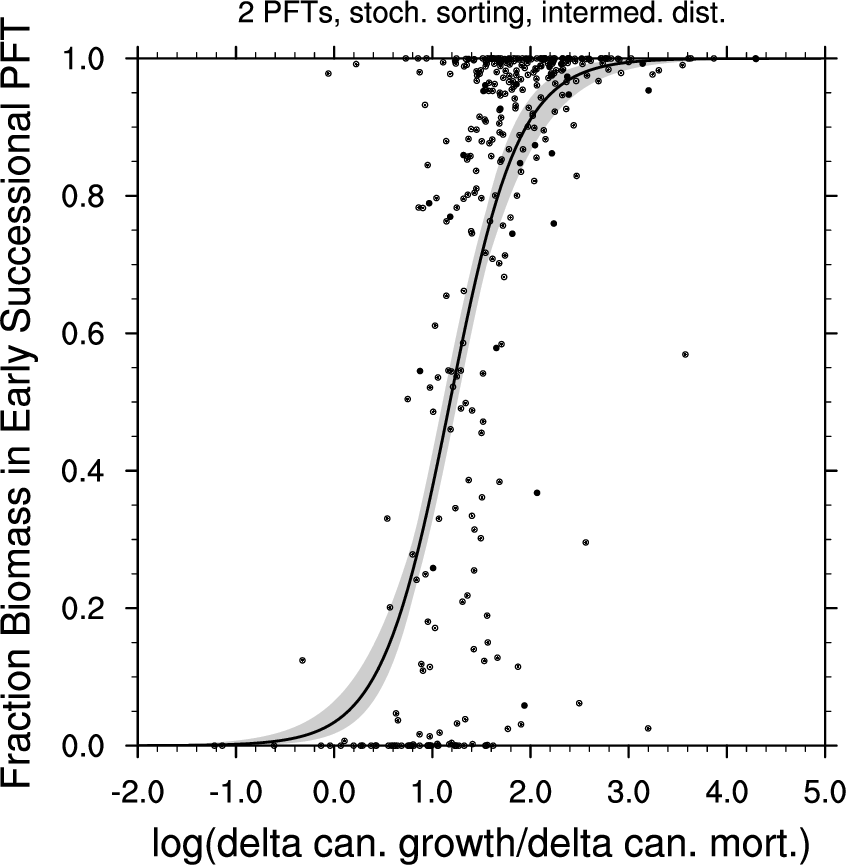

 
showing file EarlyLate_PFTbiomassfrac_cangrowthcanmort_withregression_exp1


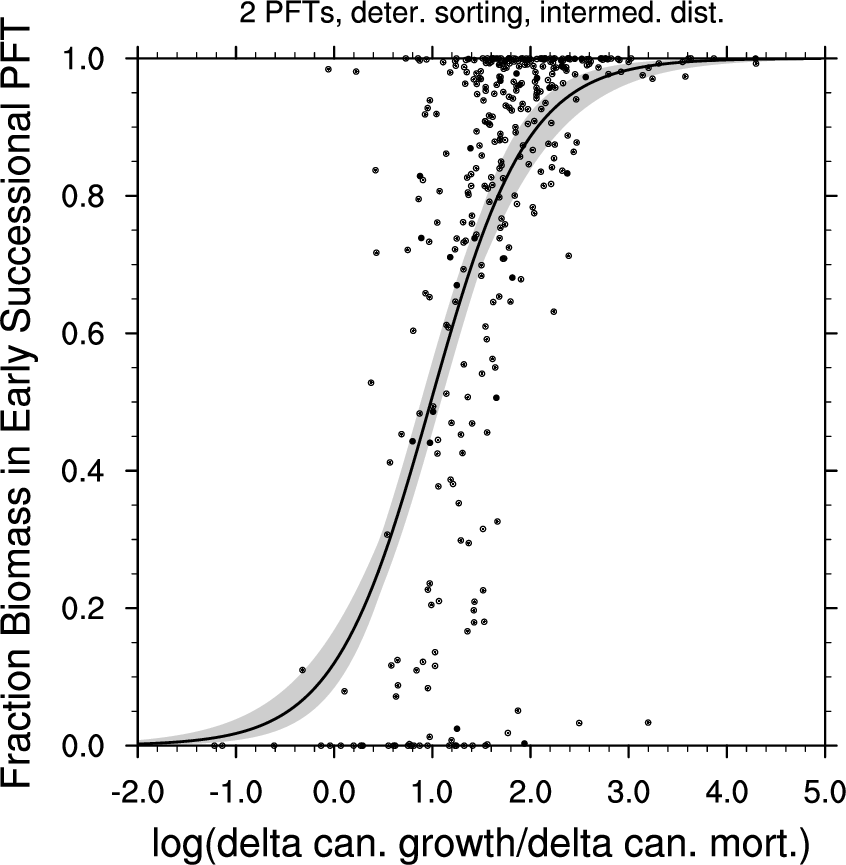

 
showing file EarlyLate_PFTbiomassfrac_cangrowthcanmort_withregression_exp2


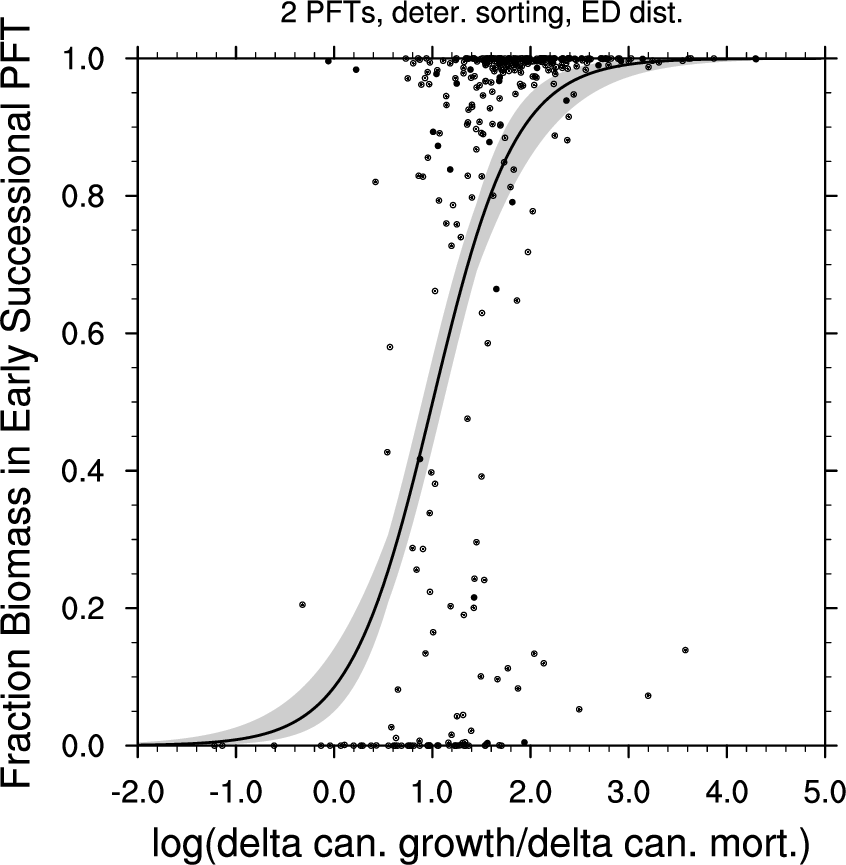

 
showing file EarlyLate_PFTbiomassfrac_cangrowthcanmort_withregression_exp3


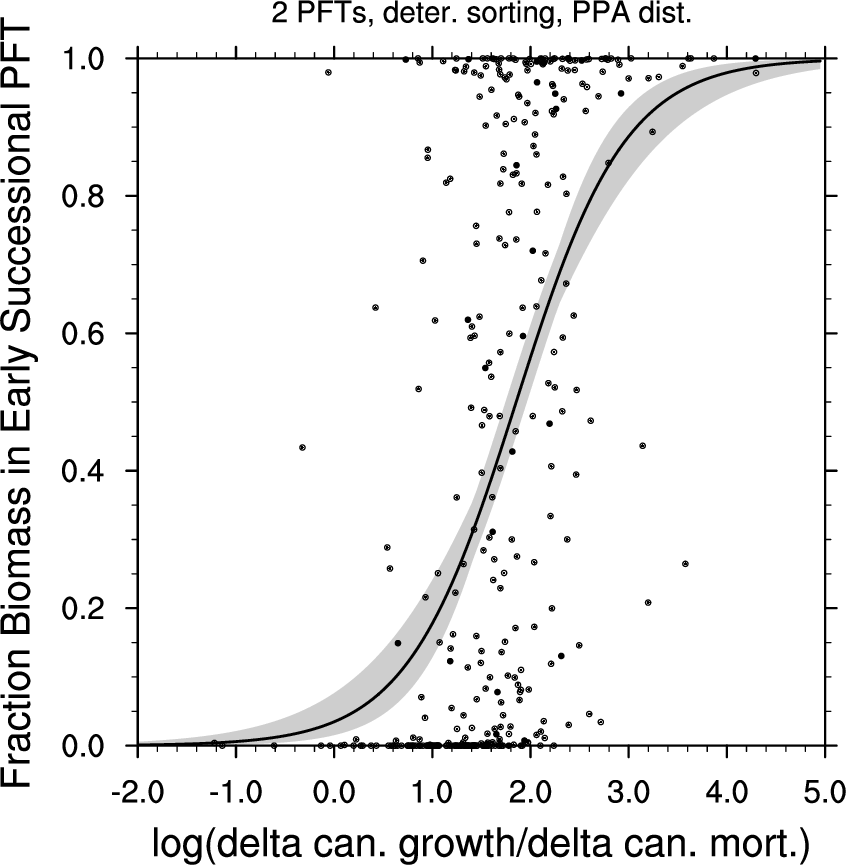

In [23]:
## plot the 2 PFT competition cases, with continuous logistic regression curves overlain on top of the ensemble outcomes
for i in range(n_2pft_exp_members):
    popt_index1, pcov_index1 = curve_fit(logisticfunc, competitiveness_index1[earlylate_index1], frac_biomass_early_pft_index1[i,earlylate_index1])
    perr = 2 * np.sqrt(np.diag(pcov_index1))
    #print(perr)
    overlay_x = np.arange(-2,5,0.05)
    overlay_y = logisticfunc(overlay_x, *popt_index1)
    overlay_yerror = np.row_stack([logisticfunc(overlay_x, popt_index1[0]+perr[0], popt_index1[1]), logisticfunc(overlay_x, popt_index1[0]-perr[0], popt_index1[1]), logisticfunc(overlay_x, popt_index1[0], popt_index1[1]+perr[1]), logisticfunc(overlay_x, popt_index1[0], popt_index1[1]-perr[1])])
    overlay_yerror_ll = overlay_yerror.min(axis=0)
    overlay_yerror_ul = overlay_yerror.max(axis=0)
    map_funcs.xyplot(competitiveness_index1, frac_biomass_early_pft_index1[i,:], dots=True, xtitle='log(delta can. growth/delta can. mort.)', ytitle='Fraction Biomass in Early Successional PFT', title=experiment_members_list_names[i_exp_2pfts][i], file='EarlyLate_PFTbiomassfrac_cangrowthcanmort_withregression_exp'+str(i), yrange=[0.,1.], xrange=[-2,5], overlay_x=overlay_x, overlay_y=overlay_y, overlay_shadederror_llimit=overlay_yerror_ll, overlay_shadederror_ulimit=overlay_yerror_ul, shadederror_opacity=0.1, showjupyter=True)


 
showing file EarlyLate_PFTbiomassfrac_cangrowthundmort_withregression_exp0


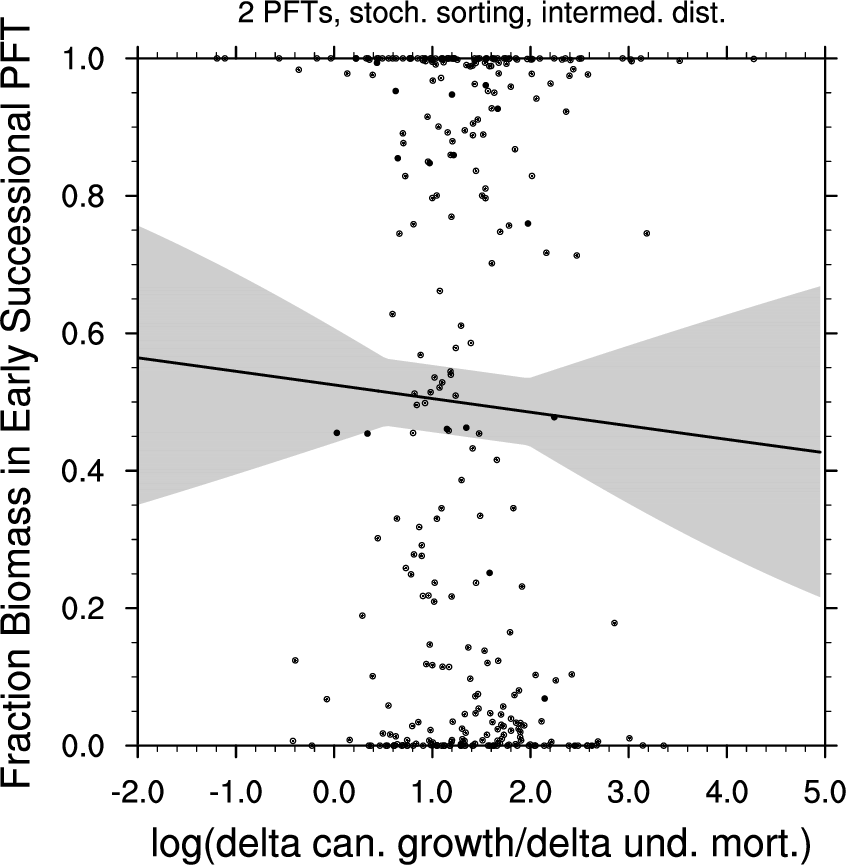

 
showing file EarlyLate_PFTbiomassfrac_cangrowthundmort_withregression_exp1


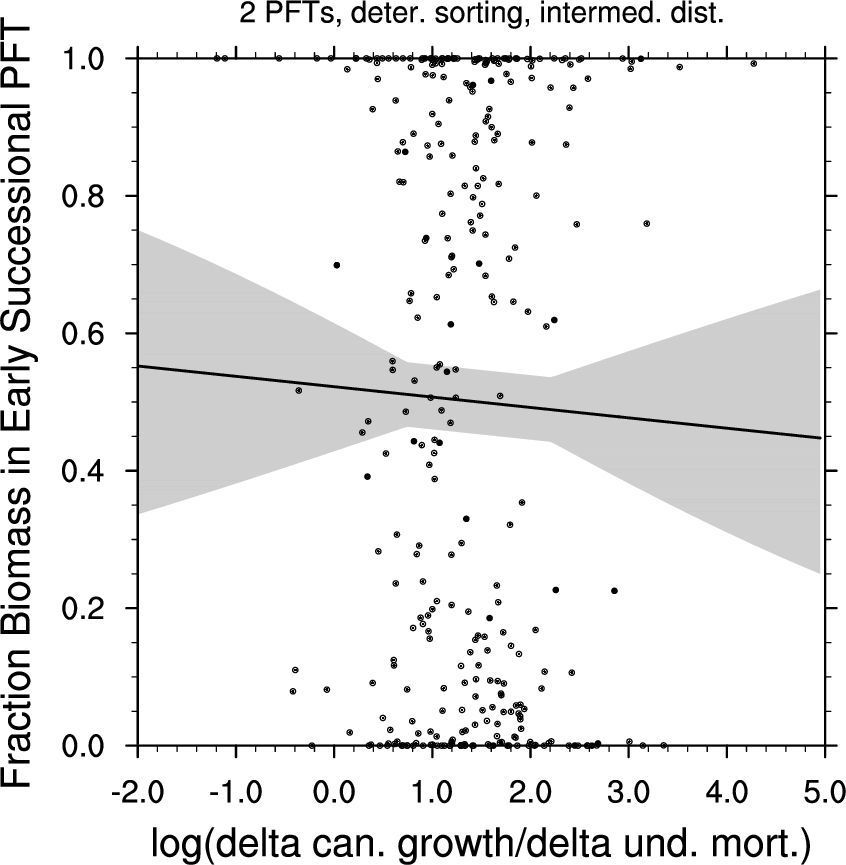

 
showing file EarlyLate_PFTbiomassfrac_cangrowthundmort_withregression_exp2


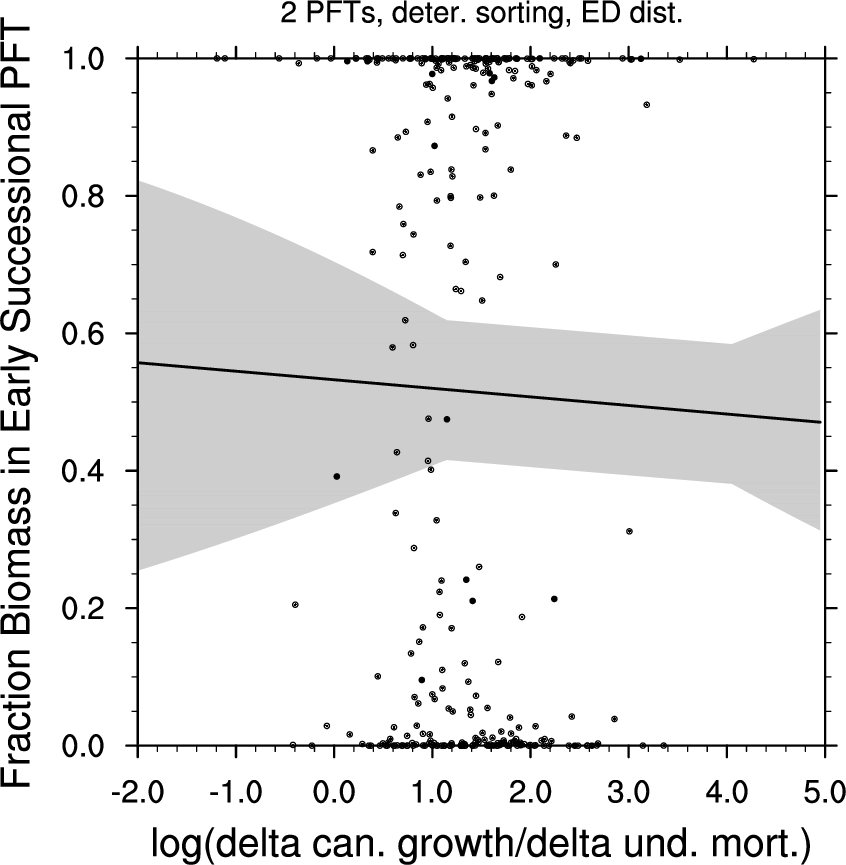

 
showing file EarlyLate_PFTbiomassfrac_cangrowthundmort_withregression_exp3


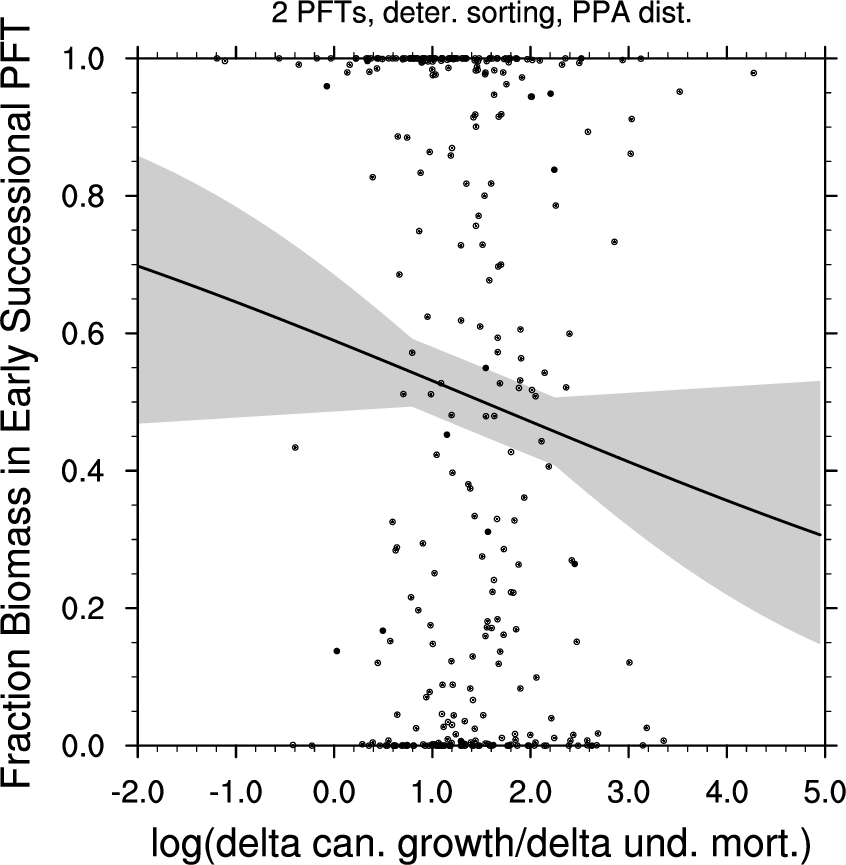

In [24]:
## polot the 2 PFT competition cases, with continuous logistic regression curves overlain on top of the ensemble outcomes
for i in range(n_2pft_exp_members):
    popt_index1, pcov_index1 = curve_fit(logisticfunc, competitiveness_index2[earlylate_index2], frac_biomass_early_pft_index2[i,earlylate_index2])
    perr = 2 * np.sqrt(np.diag(pcov_index1))
    #print(perr)
    overlay_x = np.arange(-2,5,0.05)
    overlay_y = logisticfunc(overlay_x, *popt_index1)
    overlay_yerror = np.row_stack([logisticfunc(overlay_x, popt_index1[0]+perr[0], popt_index1[1]), logisticfunc(overlay_x, popt_index1[0]-perr[0], popt_index1[1]), logisticfunc(overlay_x, popt_index1[0], popt_index1[1]+perr[1]), logisticfunc(overlay_x, popt_index1[0], popt_index1[1]-perr[1])])
    overlay_yerror_ll = overlay_yerror.min(axis=0)
    overlay_yerror_ul = overlay_yerror.max(axis=0)
    map_funcs.xyplot(competitiveness_index2, frac_biomass_early_pft_index2[i,:], dots=True, xtitle='log(delta can. growth/delta und. mort.)', ytitle='Fraction Biomass in Early Successional PFT', title=experiment_members_list_names[i_exp_2pfts][i], file='EarlyLate_PFTbiomassfrac_cangrowthundmort_withregression_exp'+str(i), yrange=[0.,1.], xrange=[-2,5], overlay_x=overlay_x, overlay_y=overlay_y, overlay_shadederror_llimit=overlay_yerror_ll, overlay_shadederror_ulimit=overlay_yerror_ul, shadederror_opacity=0.1, showjupyter=True)



 
showing file competitiveness_histograms_superiorinferior


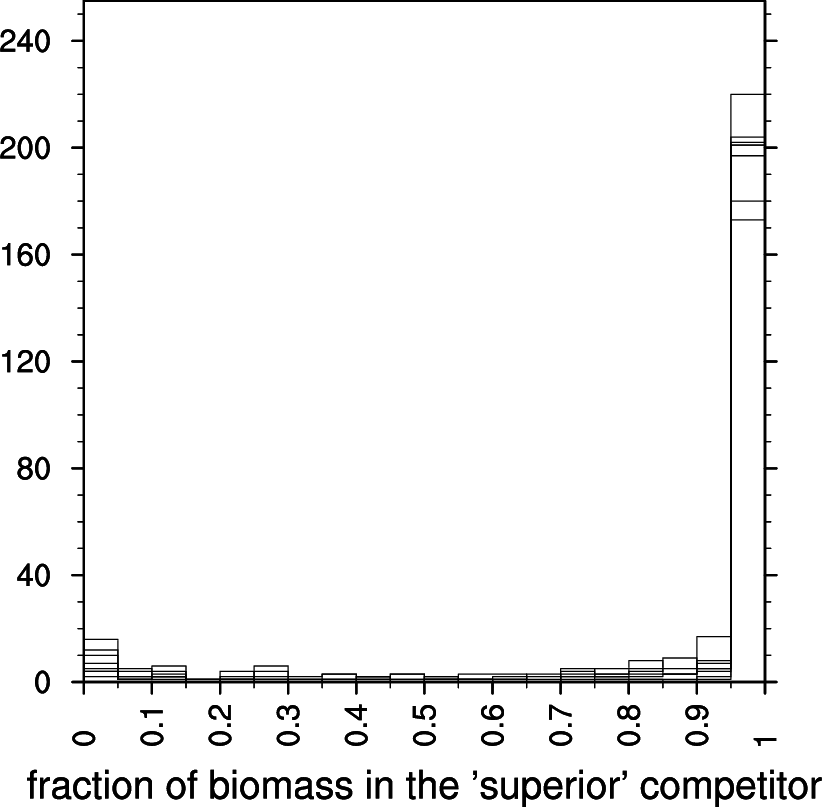

In [25]:
### plot a histogram of the relative success in the case where, insetd of an early-late tradeoff, we have a superior/inferior relationship, where we expect one PFT to dominate. 
map_funcs.plot_histogram(np.ma.row_stack([frac_biomass_superior_pft_index1[:,:],frac_biomass_superior_pft_index2[:,:]]), bins=20, therange=[0.,1.], axis=0, file='competitiveness_histograms_superiorinferior', xtitle="fraction of biomass in the 'superior' competitor", showjupyter=True)



In [26]:
print(fates_levscls[1])

1.0
